# The *additive noise annealing* algorithm

In this notebook, we will present the application of a quantization algorithm, going from the training of a floating-point network down to the deployment of a quantized neural network. 

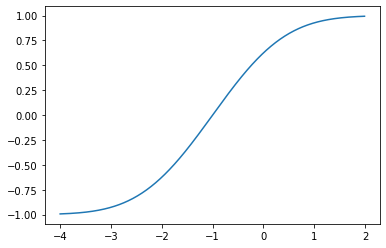

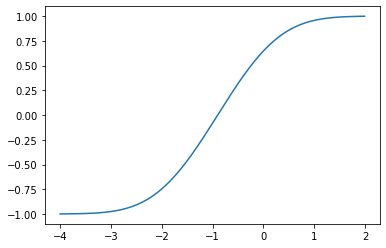

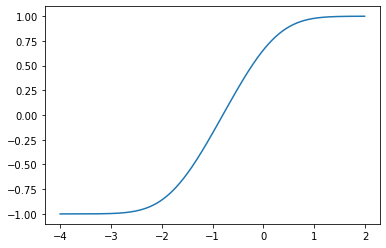

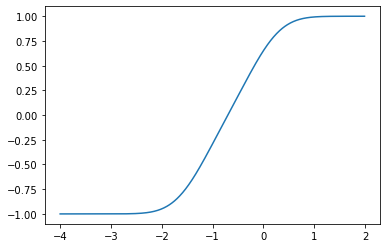

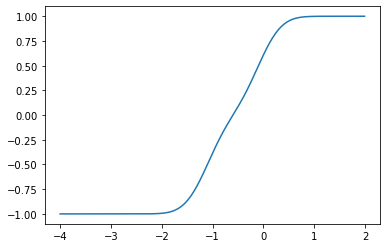

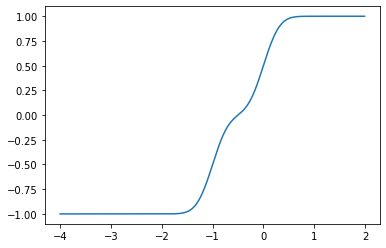

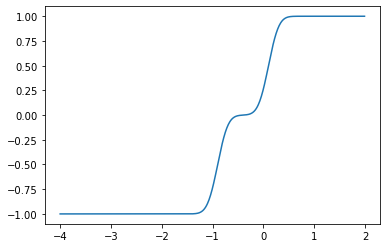

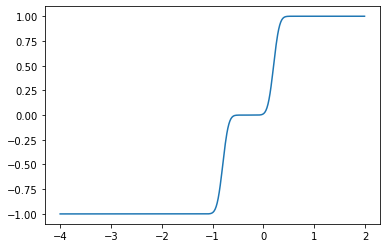

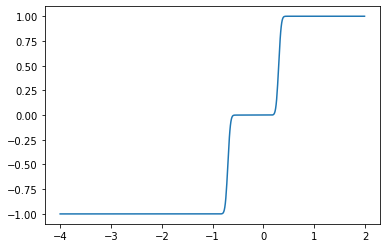

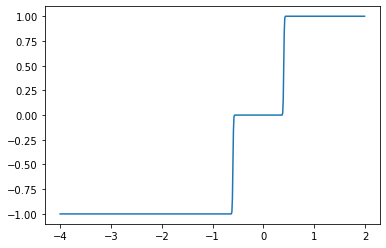

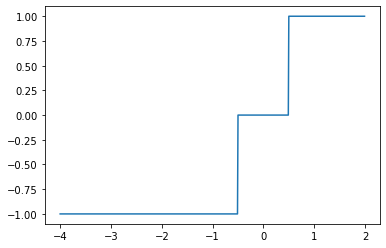

In [1]:
import torch
import matplotlib.pyplot as plt

import quantlib.algorithms as qa


act = qa.ana.ANAActivation({'nbits': 2, 'signed': True, 'balanced': True, 'eps': 1.0}, 'normal')

x = torch.arange(-4.0, 2.0, step=0.01).to(dtype=torch.float32)
x.requires_grad = False

lambda_ = torch.arange(1.0, -0.1, step=-0.1)
for l in lambda_:

    act.fnoise.mi.data    = -l
    act.fnoise.sigma.data = (-l) ** 2
    
    y = act(x)

    plt.plot(x, y)
    plt.show()


We will start by training a simple convolutional neural network.

In [2]:
import torch
import torch.nn as nn


_CONFIGS = {
    'VGG8': ['M', 256, 256, 'M', 512, 512, 'M'],
    'VGG9': [128, 'M', 256, 256, 'M', 512, 512, 'M'],
    'VGG11': [128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M'],
}


class VGG(nn.Module):

    def __init__(self, config: str, capacity: int = 1, use_bn: bool = False, num_classes: int = 10, seed: int = -1) -> None:

        super(VGG, self).__init__()

        self.pilot      = self._make_pilot(capacity, use_bn)
        self.features   = self._make_features(config, capacity, use_bn)
        self.avgpool    = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = self._make_classifier(capacity, use_bn, num_classes)

        self._initialize_weights(seed=seed)

    @staticmethod
    def _make_pilot(capacity: int, use_bn: bool) -> nn.Sequential:

        modules = []
        modules += [nn.Conv2d(3, 128 * capacity, kernel_size=3, padding=1, bias=not use_bn)]
        modules += [nn.BatchNorm2d(128 * capacity)] if use_bn else []
        modules += [nn.ReLU(inplace=True)]

        return nn.Sequential(*modules)

    @staticmethod
    def _make_features(config: str, capacity: int, use_bn: bool) -> nn.Sequential:

        modules = []
        in_channels = 128 * capacity
        for v in _CONFIGS[config]:
            if v == 'M':
                modules += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                out_channels = v * capacity
                modules += [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=not use_bn)]
                modules += [nn.BatchNorm2d(out_channels)] if use_bn else []
                modules += [nn.ReLU(inplace=True)]
                in_channels = out_channels

        return nn.Sequential(*modules)

    @staticmethod
    def _make_classifier(capacity: int, use_bn: bool, num_classes: int) -> nn.Sequential:

        modules = []
        modules += [nn.Linear(512 * capacity * 4 * 4, 1024, bias=not use_bn)]
        modules += [nn.BatchNorm1d(1024)] if use_bn else []
        modules += [nn.ReLU(inplace=True)]
        modules += [] if use_bn else [nn.Dropout()]
        modules += [nn.Linear(1024, 1024, bias=not use_bn)]
        modules += [nn.BatchNorm1d(1024)] if use_bn else []
        modules += [nn.ReLU(inplace=True)]
        modules += [] if use_bn else [nn.Dropout()]
        modules += [nn.Linear(1024, num_classes)]

        return nn.Sequential(*modules)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.pilot(x)
        x = self.features(x)
        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)  # https://stackoverflow.com/questions/57234095/what-is-the-difference-of-flatten-and-view-1-in-pytorch

        x = self.classifier(x)

        return x

    def _initialize_weights(self, seed: int):

        if seed >= 0:
            torch.manual_seed(seed)

        for m in self.modules():

            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [3]:
net = VGG('VGG8', use_bn=True)


## Converting a floating-point graph into a fake-quantized graph

The sub-packages of the ``quantlib.algorithms`` package provide the building blocks required to compose DNNs that can be trained using advanced quantization-aware training algorithms.
Of course, the user can manually define new PyTorch networks using such building blocks.

Sometimes, though, before implementing a brand-new DNN topology by hand it might be worth it to try and quantize an existing floating-point topology that has shown good performance at the target task.
In this case, the network's PyTorch definition might already be available, and it is preferable to replace its floating-point operations with counterparts that support quantization-aware training in an automated way, without the hazards inherent to manual rewriting.

The ``quantlib.editing`` package enables this functionality via the ``lightweight`` sub-package.
The name *lightweight* is used to distinguish the network transformations that it enables from the more advanced (but also more complex) transformations enabled by the ``graphs`` sub-package.
To understand the workings of the ``lightweight`` sub-package and how they differ from those of the ``graphs`` sub-package, it is necessary to understand how PyTorch represents DNNs at a high level.

PyTorch users can define DNNs as sub-classes of ``torch.nn.Module``.
We can distinguish between two main flavours of PyTorch modules:

* *basic* modules;
* *container* modules.

Basic modules represent *primitive* transformations.
Essentially, they are Python wrappers for operations that support automatic differentiation, hence enabling the execution of the back-propagation algorithm.
Container modules are, well, containers for other PyTorch modules.
The purpose of container modules is structuring the execution of their *children* modules.
For instance, the purpose of a ``torch.nn.Sequential`` module is creating a semantically coherent pipeline of transformations that should be executed one after the other.
The definition of a container module is recursive, in that the modules that it contains can be either container themselves or basic modules.
DNN definitions are almost always containers.

Differently from other deep learning frameworks such as TensorFlow, PyTorch creates computational graphs dynamically.
When a PyTorch DNN class is instantiated into a network object, it is in general not possible to determine the exact dependency relationships between its modules without passing an example input through it (a process named *tracing* in PyTorch's terminology).
However, due to the recursive nature of PyTorch modules, a PyTorch network object is represented as a **tree**.
The root and intermediate nodes of such a tree are container modules, whereas its leaves are basic modules.
Moreover, an alphanumeric string is attached to each node, allowing to refer them by name.

The ``lightweight`` sub-package implements:

* a ``LightweightGraph`` class acting as a wrapper around a PyTorch network object; despite its name, this object implements *tree traversal* functions whose purpose is "linearising" the wrapped network object, i.e., returning a list of its composing basic modules, in the form of name-module pairs (``LightweightNode`` objects);
* ``Filter`` classes that can be applied to a ``LightweightGraph`` and return handles on the modules of its wrapped network object; basic filters can act on the symbolic names or on the modules types (e.g., extracting all the convolutional operations in the network or all the operations grouped in a container module with a specific name), wherease composite filters allow to refine the search;
* ``LightweightRule`` classes that can replace all the modules returned by the application of a filter with a specified counterpart supporting the desired quantization-aware algorithm; these rules mostly operate as one-to-one swaps involving a floating-point basic module with a corresponding counterpart supporting quantization-aware training;
* a ``LightweightEditor`` class to organise the application of ``LightweightRule``s; thanks to an internal undo-redo stack-based structure, a ``LightweightEditor`` allows users to play around with tentative rules and filters until the desired conversion is achieved.

Differently from lightweight graph editing, preparing fake-quantized network for the deployment of real hardware accelerators requires to know the exact dependencies between a network's composing modules.
In this case, manipulating a network that is actually a tree is not sufficient.
Applying tracing to a PyTorch network returns bipartite, directed, acyclic graphs (bipartite DAGs) that provide all the necessary information to transform and deploy a trained fake-quantized network on real hardware.
The purpose of the ``graphs`` sub-package is exactly to provide the functionalities required in these scenarios.


In [4]:
import quantlib.editing.lightweight as qlw


graph  = qlw.LightweightGraph(net)

editor = qlw.LightweightEditor(graph)
editor.startup()
editor.pause()

editor.graph.show_nodes_list()


pilot.0                        <class 'torch.nn.modules.conv.Conv2d'>
pilot.1                        <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
pilot.2                        <class 'torch.nn.modules.activation.ReLU'>
features.0                     <class 'torch.nn.modules.pooling.MaxPool2d'>
features.1                     <class 'torch.nn.modules.conv.Conv2d'>
features.2                     <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
features.3                     <class 'torch.nn.modules.activation.ReLU'>
features.4                     <class 'torch.nn.modules.conv.Conv2d'>
features.5                     <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
features.6                     <class 'torch.nn.modules.activation.ReLU'>
features.7                     <class 'torch.nn.modules.pooling.MaxPool2d'>
features.8                     <class 'torch.nn.modules.conv.Conv2d'>
features.9                     <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
features.10               

In [5]:
# type-based filters
filter_conv2d = qlw.rules.filters.TypeFilter(nn.Conv2d)
filter_linear = qlw.rules.filters.TypeFilter(nn.Linear)
filter_relu   = qlw.rules.filters.TypeFilter(nn.ReLU)

# name-based filters
filter_pilot      = qlw.rules.filters.NameFilter('pilot')
filter_features   = qlw.rules.filters.NameFilter('features')
filter_classifier = qlw.rules.filters.NameFilter('classifier')

# composed filter example
filter_conv2d_pilot_or_features = filter_conv2d & (filter_pilot | filter_features)


for n in filter_conv2d_pilot_or_features(editor.graph.nodes_list):
    print(n.name, n.module)


features.1 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
pilot.0 Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
features.11 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
features.4 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
features.8 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [6]:
from functools import partial

import quantlib.algorithms as qa


def replace_conv2d_anaconv2d(module:         nn.Module,
                             quantizer_spec: dict,
                             noise_type:     str):
    
    assert isinstance(module, nn.Conv2d)

    return qa.ana.ANAConv2d(in_channels=module.in_channels,
                            out_channels=module.out_channels,
                            kernel_size=module.kernel_size,
                            stride=module.stride,
                            padding=module.padding,
                            dilation=module.dilation,
                            groups=module.groups,
                            bias=module.bias,
                            quantizer_spec=quantizer_spec,
                            noise_type=noise_type)


class ANAConv2dRule(qlw.rules.LightweightRule):
    
    def __init__(self,
                 filter_:        qlw.rules.filters.Filter,
                 quantizer_spec: dict,
                 noise_type:     str):

        replacement_fun = partial(replace_conv2d_anaconv2d, quantizer_spec=quantizer_spec, noise_type=noise_type)
        super(ANAConv2dRule, self).__init__(filter_=filter_, replacement_fun=replacement_fun)


In [7]:
rho_conv2d = ANAConv2dRule(filter_conv2d_pilot_or_features, {'nbits': 2, 'signed': True, 'balanced': True, 'eps': 1.0}, 'uniform')

editor.resume()
editor.set_lwr(rho_conv2d)
editor.apply()
editor.pause()

editor.graph.show_nodes_list()


pilot.0                        <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
pilot.1                        <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
pilot.2                        <class 'torch.nn.modules.activation.ReLU'>
features.0                     <class 'torch.nn.modules.pooling.MaxPool2d'>
features.1                     <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
features.2                     <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
features.3                     <class 'torch.nn.modules.activation.ReLU'>
features.4                     <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
features.5                     <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
features.6                     <class 'torch.nn.modules.activation.ReLU'>
features.7                     <class 'torch.nn.modules.pooling.MaxPool2d'>
features.8                     <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
features.9                     <class 'torch.nn.module

In [8]:
def replace_linear_analinear(module:         torch.nn.Module,
                             quantizer_spec: dict,
                             noise_type:     str):
    
    assert isinstance(module, torch.nn.Linear)
    
    return qa.ana.ANALinear(in_features=module.in_features,
                            out_features=module.out_features,
                            bias=module.bias,
                            quantizer_spec=quantizer_spec,
                            noise_type=noise_type)


class ANALinearRule(qlw.rules.LightweightRule):
    
    def __init__(self,
                 filter_:        qlw.rules.filters.Filter,
                 quantizer_spec: dict,
                 noise_type:     str):
        
        replacement_fun = partial(replace_linear_analinear, quantizer_spec=quantizer_spec, noise_type=noise_type)
        super(ANALinearRule, self).__init__(filter_=filter_, replacement_fun=replacement_fun)



def replace_relu_anaact(module:         torch.nn.Module,
                        quantizer_spec: dict,
                        noise_type:     str):
    
    assert isinstance(module, torch.nn.ReLU)
    return qa.ana.ANAActivation(quantizer_spec=quantizer_spec, noise_type=noise_type)


class ANAActivationRule(qlw.rules.LightweightRule):
    
    def __init__(self,
                 filter_:        qlw.rules.filters.Filter,
                 quantizer_spec: dict,
                 noise_type:     str):
        
        replacement_fun = partial(replace_relu_anaact, quantizer_spec=quantizer_spec, noise_type=noise_type)
        super(ANAActivationRule, self).__init__(filter_=filter_, replacement_fun=replacement_fun)


In [9]:
filter_last_layer = qlw.rules.filters.NameFilter('classifier.6')
filter_linear_classifier_no_last = filter_linear & filter_classifier & (-filter_last_layer)
rho_linear = ANALinearRule(filter_linear_classifier_no_last, {'nbits': 2, 'signed': True, 'balanced': True, 'eps': 1.0}, 'uniform')

filter_relu_pilot_or_features_or_classifier = filter_relu & (filter_pilot | filter_features | filter_classifier)
rho_relu = ANAActivationRule(filter_relu_pilot_or_features_or_classifier, {'nbits': 2, 'signed': True, 'balanced': True, 'eps': 1.0}, 'uniform')

editor.resume()
editor.set_lwr(rho_linear)
editor.apply()
editor.set_lwr(rho_relu)
editor.apply()
editor.pause()

editor.graph.show_nodes_list()


pilot.0                        <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
pilot.1                        <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
pilot.2                        <class 'quantlib.algorithms.ana.ana_ops.ANAActivation'>
features.0                     <class 'torch.nn.modules.pooling.MaxPool2d'>
features.1                     <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
features.2                     <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
features.3                     <class 'quantlib.algorithms.ana.ana_ops.ANAActivation'>
features.4                     <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
features.5                     <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
features.6                     <class 'quantlib.algorithms.ana.ana_ops.ANAActivation'>
features.7                     <class 'torch.nn.modules.pooling.MaxPool2d'>
features.8                     <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
features.9     

When we are happy with the transformation applied to the graph (i.e., when we are sure that we replaced the intended modules with the quantized counterparts), we can *shut down* the editor.
This operation will destroy the editing history, and it will be impossible to bring the network back into the state it was in before the editing.


In [10]:
editor.shutdown()


In [11]:
from quantlib.algorithms.ana.ana_controller import ANAController


ctrl_spec = [
    {
        'modules': ['pilot.0', 'pilot.2'],
        'fnoise': {
            'mi':    {'base': -0.0, 'fun': 'lws', 'kwargs': {'tstart': 0, 'tend': 50, 'alpha': 1}},
            'sigma': {'base':  0.0, 'fun': 'lws', 'kwargs': {'tstart': 0, 'tend': 50, 'alpha': 2}}
        },
        'bnoise': {
            'mi':    {'base': -0.0, 'fun': 'lws', 'kwargs': {'tstart': 0, 'tend': 50, 'alpha': 1}},
            'sigma': {'base':  0.0, 'fun': 'lws', 'kwargs': {'tstart': 0, 'tend': 50, 'alpha': 2}}
        }
    },
    {
        'modules': ['features.1', 'features.3'],
        'fnoise': {
            'mi':    {'base': -0.0, 'fun': 'lws', 'kwargs': {'tstart': 5, 'tend': 50, 'alpha': 1}},
            'sigma': {'base':  0.0, 'fun': 'lws', 'kwargs': {'tstart': 5, 'tend': 50, 'alpha': 2}}
        },
        'bnoise': {
            'mi':    {'base': -0.0, 'fun': 'lws', 'kwargs': {'tstart': 5, 'tend': 50, 'alpha': 1}},
            'sigma': {'base':  0.0, 'fun': 'lws', 'kwargs': {'tstart': 5, 'tend': 50, 'alpha': 2}}
        }
    },
    {
        'modules': ['features.4', 'features.6'],
        'fnoise': {
            'mi':    {'base': -0.0, 'fun': 'lws', 'kwargs': {'tstart': 10, 'tend': 50, 'alpha': 1}},
            'sigma': {'base':  0.0, 'fun': 'lws', 'kwargs': {'tstart': 10, 'tend': 50, 'alpha': 2}}
        },
        'bnoise': {
            'mi':    {'base': -0.0, 'fun': 'lws', 'kwargs': {'tstart': 10, 'tend': 50, 'alpha': 1}},
            'sigma': {'base':  0.0, 'fun': 'lws', 'kwargs': {'tstart': 10, 'tend': 50, 'alpha': 2}}
        }
    },
    {
        'modules': ['features.8', 'features.10'],
        'fnoise': {
            'mi':    {'base': -0.0, 'fun': 'lws', 'kwargs': {'tstart': 15, 'tend': 50, 'alpha': 1}},
            'sigma': {'base':  0.0, 'fun': 'lws', 'kwargs': {'tstart': 15, 'tend': 50, 'alpha': 2}}
        },
        'bnoise': {
            'mi':    {'base': -0.0, 'fun': 'lws', 'kwargs': {'tstart': 15, 'tend': 50, 'alpha': 1}},
            'sigma': {'base':  0.0, 'fun': 'lws', 'kwargs': {'tstart': 15, 'tend': 50, 'alpha': 2}}
        }
    },
    {
        'modules': ['features.11', 'features.13'],
        'fnoise': {
            'mi':    {'base': -0.0, 'fun': 'lws', 'kwargs': {'tstart': 20, 'tend': 50, 'alpha': 1}},
            'sigma': {'base':  0.0, 'fun': 'lws', 'kwargs': {'tstart': 20, 'tend': 50, 'alpha': 2}}
        },
        'bnoise': {
            'mi':    {'base': -0.0, 'fun': 'lws', 'kwargs': {'tstart': 25, 'tend': 50, 'alpha': 1}},
            'sigma': {'base':  0.0, 'fun': 'lws', 'kwargs': {'tstart': 25, 'tend': 50, 'alpha': 2}}
        }
    },
    {
        'modules': ['classifier.0', 'classifier.2'],
        'fnoise': {
            'mi':    {'base': -0.0, 'fun': 'lws', 'kwargs': {'tstart': 30, 'tend': 50, 'alpha': 1}},
            'sigma': {'base':  0.0, 'fun': 'lws', 'kwargs': {'tstart': 30, 'tend': 50, 'alpha': 2}}
        },
        'bnoise': {
            'mi':    {'base': -0.0, 'fun': 'lws', 'kwargs': {'tstart': 30, 'tend': 50, 'alpha': 1}},
            'sigma': {'base':  0.0, 'fun': 'lws', 'kwargs': {'tstart': 30, 'tend': 50, 'alpha': 2}}
        }
    },
    {
        'modules': ['classifier.3', 'classifier.5'],
        'fnoise': {
            'mi':    {'base': -0.0, 'fun': 'lws', 'kwargs': {'tstart': 35, 'tend': 50, 'alpha': 1}},
            'sigma': {'base':  0.0, 'fun': 'lws', 'kwargs': {'tstart': 35, 'tend': 50, 'alpha': 2}}
        },
        'bnoise': {
            'mi':    {'base': -0.0, 'fun': 'lws', 'kwargs': {'tstart': 35, 'tend': 50, 'alpha': 1}},
            'sigma': {'base':  0.0, 'fun': 'lws', 'kwargs': {'tstart': 35, 'tend': 50, 'alpha': 2}}
        }
    }
]


anactrl = ANAController(net, ctrl_spec)


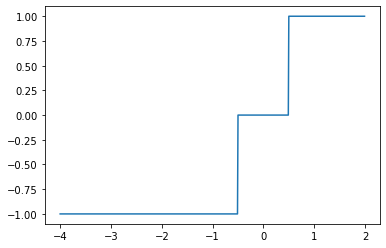

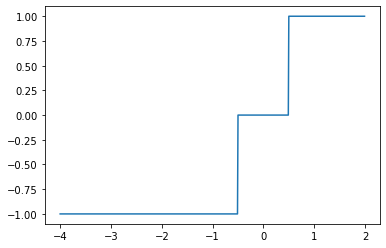

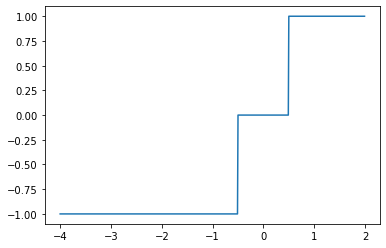

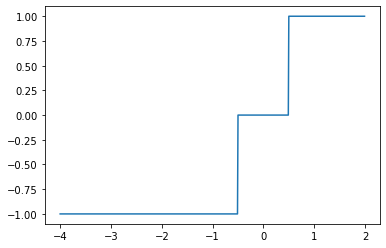

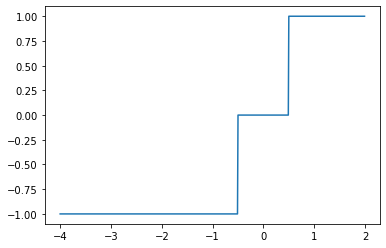

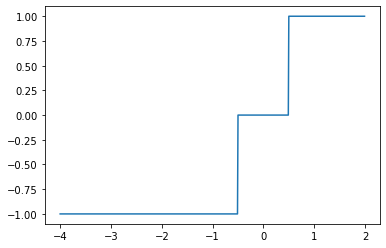

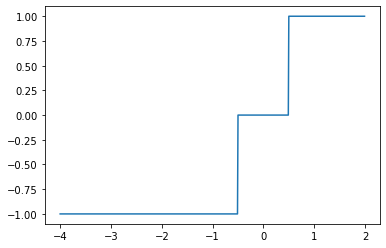

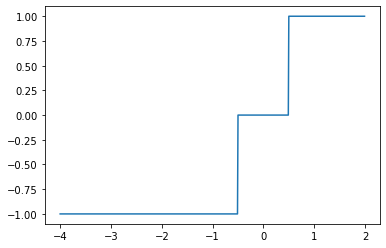

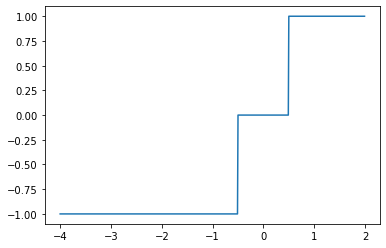

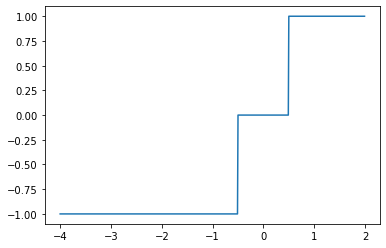

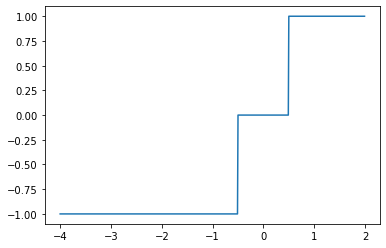

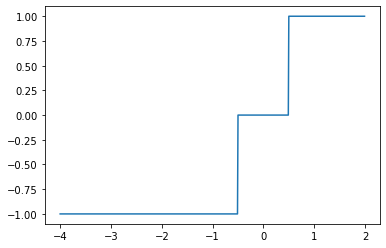

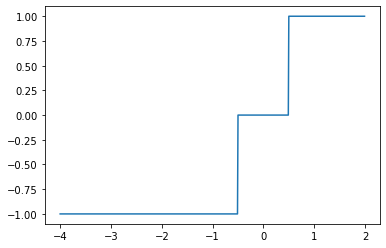

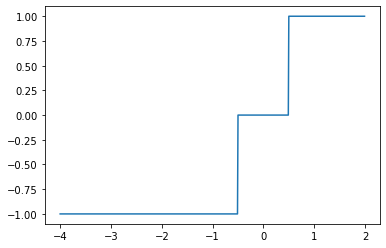

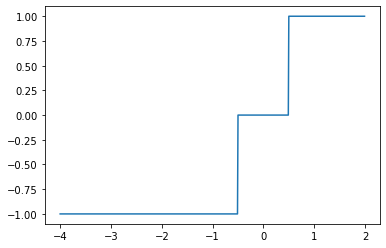

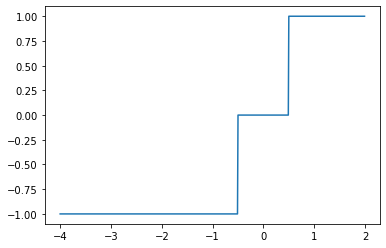

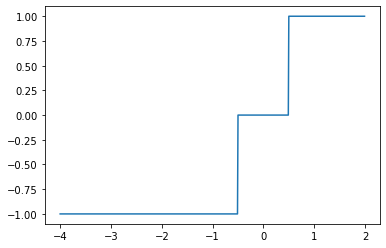

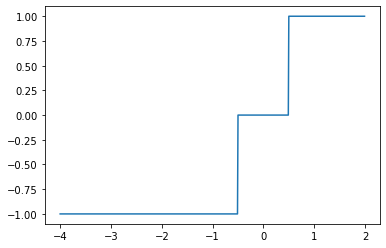

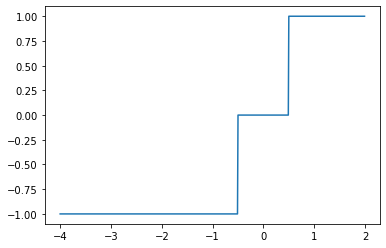

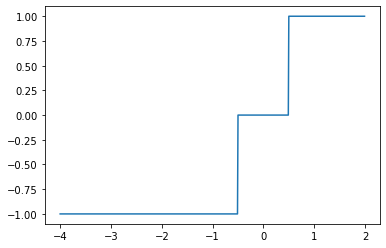

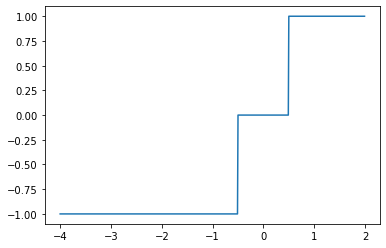

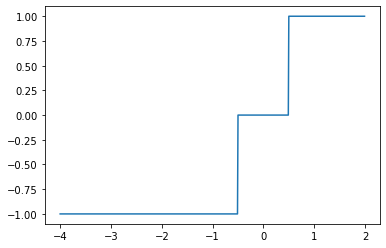

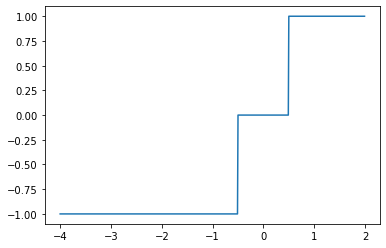

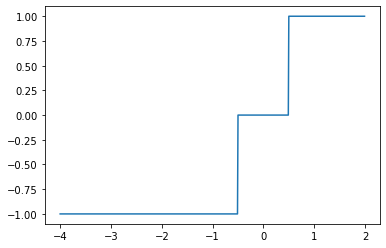

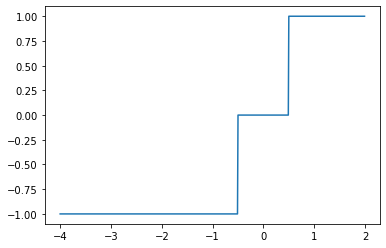

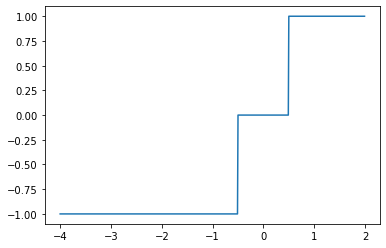

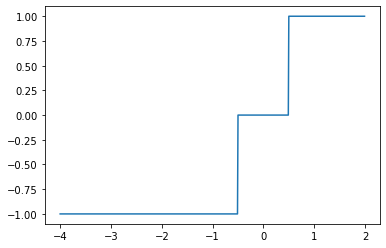

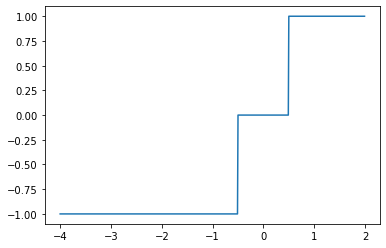

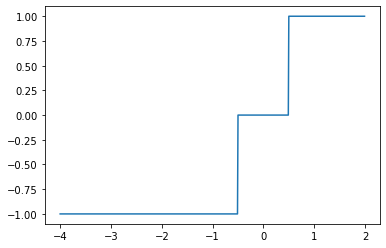

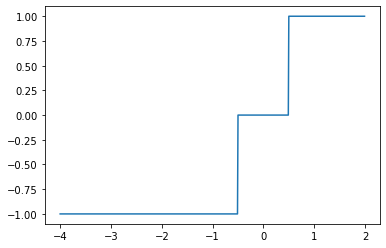

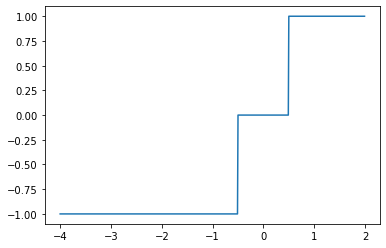

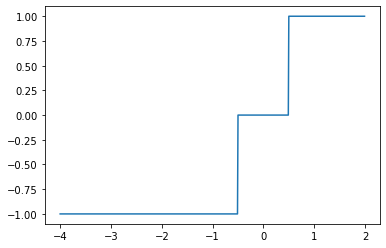

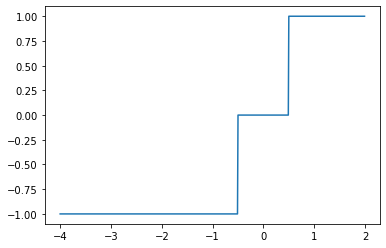

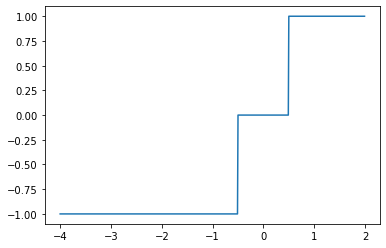

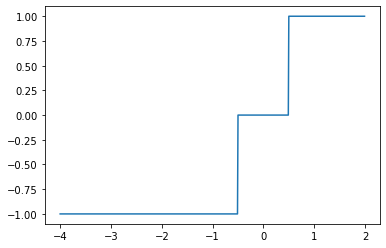

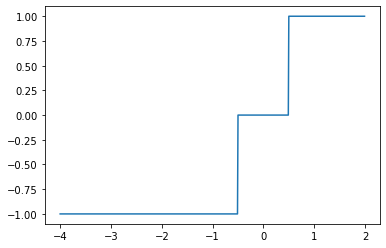

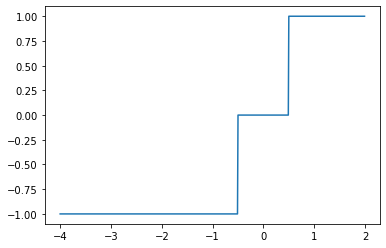

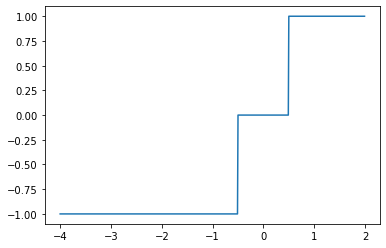

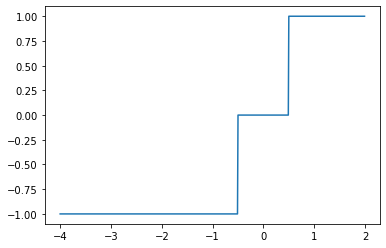

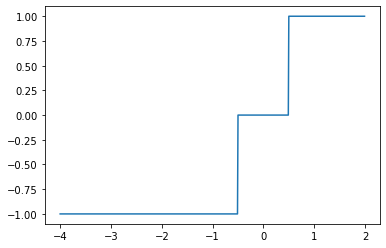

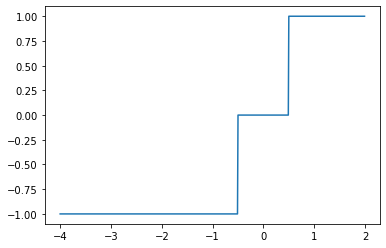

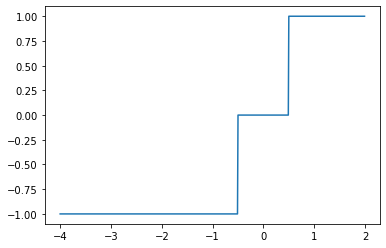

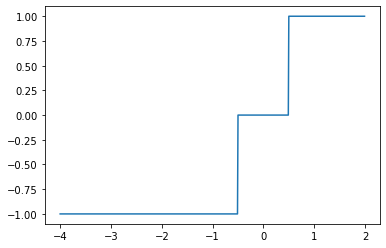

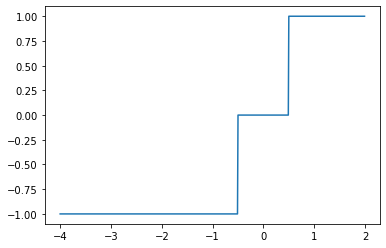

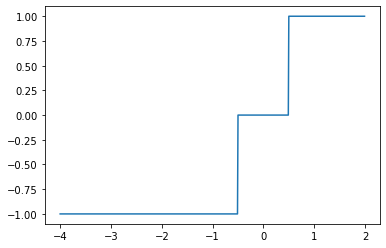

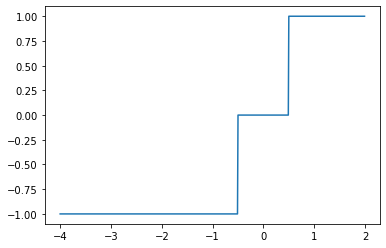

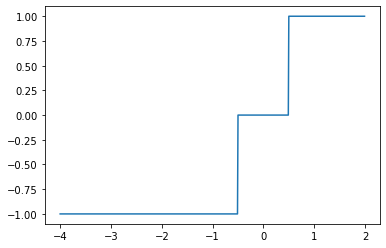

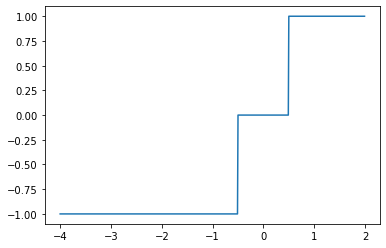

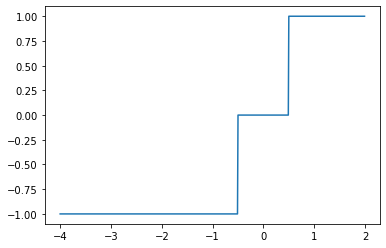

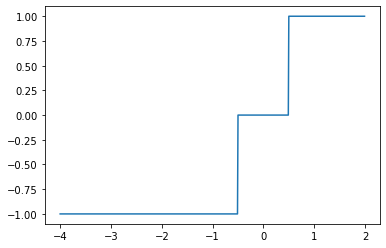

In [12]:
for t in range(0, 50):
    anactrl.step_pre_training()
    y = anactrl._n2m['pilot.2'](x)
    plt.plot(x, y)
    plt.show()


## Converting a fake-quantized graph into a true-quantized one

After training, a fake-quantized network is in general not yet ready to be executed on energy-efficient hardware.
Most operations inside a fake-quantized network still require floating-point arithmetic; a good example is provided by batch normalisation modules, where the channel means, standard deviations, weights and biases are represented by floating-point numbers.

Before tracing a fake-quantized graph, be sure to freeze its data-dependent parameters to their data-independent versions (e.g., the channel means and standard deviations tracked by batch normalisation modules).
At runtime it is generally preferable **not** using data-dependent parameters, since this degree of freedom makes it easier to conceive optimisations.
Moreover, in the specific case of networks that include batch normalisation layers, it is impossible to trace such networks by passing batches that include a single data point when the networks are not set in "evaluation" mode; this is due to the fact that computing the sample standard deviation associated with a sample that contains less than two data points is impossible by definition.


In [13]:
import quantlib.editing.graphs as qg

net.eval()

onnxg = qg.graphs.ONNXGraph(net, torch.randn((1, 3, 32, 32)))


/Users/spmatteo/anaconda3/envs/jupyter/lib/python3.8/site-packages/torch/onnx/symbolic_helper.py:677: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to inference mode. The model will be exported in inference, as specified by the export mode.
  warnings.warn("ONNX export mode is set to " + training_mode +


In [14]:
qg.utils.draw_graph(onnxg.nx_graph, '.', 'VGG8_ANA')

from IPython.display import HTML
HTML('<iframe src=./VGG8_ANA.pdf width=900 height=300></iframe>')

/Users/spmatteo/anaconda3/envs/jupyter/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [15]:
import networkx as nx

nx.get_node_attributes(onnxg.nx_graph, 'scope')

{'O000020': 'features.6',
 'O000009': 'features.1',
 'O000024': 'features.8',
 'O000029': 'features.10',
 'O000047': 'classifier.0',
 'O000010': 'features.1',
 'O000033': 'features.12',
 'O000003': 'pilot.1',
 'O000017': 'features.4',
 'O000026': 'features.9',
 'O000032': 'features.11',
 'O000008': 'features.1',
 'O000038': 'avgpool',
 'O000007': 'features.0',
 'O000012': 'features.3',
 'O000048': 'classifier.0',
 'O000036': 'features.13',
 'O000053': 'classifier.3',
 'O000055': 'classifier.3',
 'O000060': 'classifier.5',
 'O000015': 'features.4',
 'O000004': 'pilot.2',
 'O000006': 'pilot.2',
 'O000014': 'features.3',
 'O000050': 'classifier.2',
 'O000057': 'classifier.4',
 'O000030': 'features.11',
 'O000049': 'classifier.1',
 'O000034': 'features.13',
 'O000018': 'features.5',
 'O000021': 'features.6',
 'O000058': 'classifier.5',
 'O000001': 'pilot.0',
 'O000023': 'features.8',
 'O000044': '',
 'O000056': 'classifier.3',
 'O000025': 'features.8',
 'O000000': 'pilot.0',
 'O000035': 'f

In [16]:
onnxe = qg.editor.Editor(onnxg)

onnxe.startup()
for mod_name, rho in qg.grrules.load_rescoping_rules(modules=['AdaptiveAvgPool2d', 'ViewFlattenNd', 'ANAActivation', 'ANAConv2d', 'ANALinear']).items():
    print("Applying rule {} to `nn.Module`s of type {} ...".format(type(rho), mod_name))
    onnxe.set_grr(rho)
    onnxe.edit()
onnxe.shutdown()


Temporary cache directory created at /var/folders/6h/rm9g6bs143g4mvwfh3fd7_jw0000gq/T/tmpjj9rwbze
Applying rule <class 'quantlib.editing.graphs.grrules.dporules.AutoRescopingRule'> to `nn.Module`s of type AdaptiveAvgPool2d ...
Applying rule <class 'quantlib.editing.graphs.grrules.dporules.ManualRescopingRule'> to `nn.Module`s of type ViewFlattenNd ...
Applying rule <class 'quantlib.editing.graphs.grrules.dporules.AutoRescopingRule'> to `nn.Module`s of type ANAActivation ...
Applying rule <class 'quantlib.editing.graphs.grrules.dporules.AutoRescopingRule'> to `nn.Module`s of type ANAConv2d ...
An issue arose while applying rule <class 'quantlib.editing.graphs.grrules.dporules.AutoRescopingRule'> to graph <> at point: 
	 O000017 L-term/O000002
	 D000064 K-term/D000011
	 D000053 L-term/D000009
	 O000014 L-term/O000001
	 D000052 L-term/D000007
	 O000013 L-term/O000000
	 D000051 K-term/D000006
	 D000047 K-term/D000004
	 D000063 K-term/D000010
	 D000049 K-term/D000003
	 D000044 K-term/D00000

In [17]:
pytorchg = qg.graphs.PyTorchGraph(net, onnxg)

pytorche = qg.editor.Editor(pytorchg, onlykernel=True)

qg.utils.draw_graph(pytorche.G, '.', 'VGG8_ANA_PT')
HTML('<iframe src=./VGG8_ANA_PT.pdf width=900 height=300></iframe>')

/Users/spmatteo/anaconda3/envs/jupyter/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [18]:
pytorche.add_io_handles()

qg.utils.draw_graph(pytorche.G, '.', 'VGG8_ANA_PT')
HTML('<iframe src=./VGG8_ANA_PT.pdf width=900 height=300></iframe>')

Temporary cache directory created at /var/folders/6h/rm9g6bs143g4mvwfh3fd7_jw0000gq/T/tmp7f8gsvpp


/Users/spmatteo/anaconda3/envs/jupyter/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [19]:
pytorche.resume()
pytorche.set_grr(qg.grrules.AddPrecisionTunnelRule(qa.ana.ANAActivation.__name__))
pytorche.edit()
pytorche.pause()


In [20]:
qg.utils.draw_graph(pytorche.G, '.', 'VGG8_ANA_PT')
HTML('<iframe src=./VGG8_ANA_PT.pdf width=900 height=300></iframe>')


/Users/spmatteo/anaconda3/envs/jupyter/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Arithmetic conversion: *folding* and *casting*

After preparing a network for fake-to-true transformation, it is time to, well, transform it!
Apart from graph rewriting, this transformation requires reordering some operations, folding together some operands and casting them to integer or anyway low-precision data formats to preserve functional equivalence (or at least to minimise the discrepancy between the original version and the converted one).
We refer to this part of the conversion as *arithmetic conversion*.


### *Folding*

We call *folding* each sequence of applications of basic arithmetical properties or identity decompositions used to transform a given sequence of operations into an equivalent one.
Commonly-used arithmetical properties are:

* the *commutative* property: $a + b = b + a$;
* the *associative* property: $(a + b) + c = a + (b + c)$;
* the *distributive* property and its inverse: $(a + b) * c = (a * c) + (b * c)$ and $(a * c) + (b * c) = (a + b) * c$.

Given a non-zero number $z \in \mathbb{R}$, the identity decompositions are the following:

* *sum-and-subtract*: $x = x - z + z$;
* *divide-and-multiply*: $ x = (x / z) * z$.

For example, consider the operation of normalising a scalar product.
Let $n > 0$ be an integer, $\mathbb{R}^{n}$ be the $n$-dimensional Euclidean space, and $\mathbf{x}, \mathbf{w} \in \mathbb{R}^{n}$ be vectors.
Let also $\mu \in \mathbb{R},\, \sigma \in \mathbb{R}^{+}$, and consider the following operation:

\begin{equation*}
    \frac{\langle \mathbf{x}, \mathbf{w} \rangle - \mu}{\sigma} \,.
\end{equation*}

Folding rules (in this specific case, the distributive property) allow us to rewrite this operation as

\begin{equation*}
\begin{split}
    \frac{\langle \mathbf{x}, \mathbf{w} \rangle - \mu}{\sigma}
    &= \left( \langle \mathbf{x}, \mathbf{w} \rangle - \mu \right) \frac{1}{\sigma} \\
    &= \langle \mathbf{x}, \mathbf{w} \rangle \frac{1}{\sigma} - \frac{\mu}{\sigma} \\
    &= \langle \mathbf{x}, \mathbf{w} \rangle \tilde{\sigma} + \tilde{\mu} \,.
\end{split}
\end{equation*}

The critical point here is that the operands $\tilde{\sigma} = 1/\sigma \in \mathbb{R}^{+}$ and $\tilde{\mu} = -\mu/\sigma$ can be **pre-computed** starting from the operands $\mu$ and $\sigma$.
The original version of the operation involves computing the scalar product $\langle \mathbf{x}, \mathbf{w} \rangle = \sum_{i=1}^{n} x_{i} w_{i}$ ($n$ multiplications and $n-1$ sums), one subtraction, and one division.
By contrast, the folded version still requires computing the scalar product, but then uses a multiplication and an addition.

In this case, we are still performing the same number of operations, although with different operands.
In other cases, though, the benefits of folding can become more apparent.
For example, instead of supposing $\mathbf{x}, \mathbf{w} \in \mathbb{R}^{n}$, we can imagine that the components of these vectors take values in specific spaces of the form

\begin{equation*}
    \mathbb{Z}_{\epsilon} := \{ \epsilon i \,|\, i \in \mathbb{Z} \} \,,
\end{equation*}

where $\epsilon \in \mathbb{R}^{+}$ is a positive constant.
In particular, given constants $\epsilon_{\mathbf{x}}, \epsilon_{\mathbf{w}} > 0$ we assume that $\mathbf{x} \in \mathbb{Z}_{\epsilon_{\mathbf{x}}}^{n}$ and $\mathbf{w} \in \mathbb{Z}_{\epsilon_{\mathbf{w}}}^{n}$.
Due to the definition of the spaces $\mathbb{Z}_{\epsilon}$, we can make explicit the fact that each $\mathbf{x} \in \mathbb{Z}_{\epsilon_{\mathbf{x}}}^{n}$ can be rewritten as

\begin{equation*}
    \mathbf{x} = \epsilon_{\mathbf{x}} \hat{\mathbf{x}} \,,
\end{equation*}

where $\hat{\mathbf{x}} \in \mathbb{Z}^{n}$ if a vector with integer components $\hat{x}_{i} \in \mathbb{Z}, \, i = 1, \dots, n$.
An analogous representation is available for $\mathbf{w} \in \mathbb{Z}_{\epsilon_{\mathbf{w}}}^{n}$: $\mathbf{w} = \epsilon_{\mathbf{w}} \hat{\mathbf{w}}$.

Given parameters $\gamma, \beta \in \mathbb{R}$ and a positive parameter $\epsilon_{\mathbf{s}} > 0$, a conversion that is often required in fake-to-true network transformations is the following:

\begin{equation*}
\begin{split}
    \frac{\left( \frac{\langle \mathbf{x}, \mathbf{w} \rangle - \mu}{\sigma} \right) \gamma + \beta}{\epsilon_{\mathbf{s}}}
    &= \frac{\left( \frac{\langle \epsilon_{\mathbf{x}} \hat{\mathbf{x}}, \epsilon_{\mathbf{w}} \hat{\mathbf{w}} \rangle - \mu}{\sigma} \right) \gamma + \beta}{\epsilon_{\mathbf{s}}} \\
    &= \left( \left( \frac{ \sum_{i=1}^{n} \epsilon_{\mathbf{x}} \hat{x}_{i} \epsilon_{\mathbf{w}} \hat{w}_{i} - \mu}{\sigma} \right) \gamma + \beta \right) \frac{1}{\epsilon_{\mathbf{s}}} \\
    &= \left( \left( \frac{ \epsilon_{\mathbf{x}} \epsilon_{\mathbf{w}} \sum_{i=1}^{n} \hat{x}_{i} \hat{w}_{i} - \mu}{\sigma} \right) \gamma + \beta \right) \frac{1}{\epsilon_{\mathbf{s}}} \\
    &= \left( \left( \frac{ \epsilon_{\mathbf{x}} \epsilon_{\mathbf{w}} \langle \hat{\mathbf{x}}, \hat{\mathbf{w}} \rangle - \mu}{\sigma} \right) \gamma + \beta \right) \frac{1}{\epsilon_{\mathbf{s}}} \\
    &= \left( \langle \hat{\mathbf{x}}, \hat{\mathbf{w}} \rangle \left( \frac{\epsilon_{\mathbf{x}} \epsilon_{\mathbf{w}} \gamma}{\sigma} \right) + \left( \frac{\sigma \beta - \mu \gamma}{\sigma} \right) \right) \frac{1}{\epsilon_{\mathbf{s}}} \,.
\end{split}
\end{equation*}

At this point, the folding process can evolve in two directions: the *add-then-multiply*, and the *multiply-then-add*.
The *add-then-multiply* folding strategy divides the first factor by $(\epsilon_{\mathbf{x}} \epsilon_{\mathbf{w}} \gamma)/\sigma$ and multiplies the second by the same value, obtaining

\begin{equation*}
\begin{split}
    \frac{\left( \frac{\langle \mathbf{x}, \mathbf{w} \rangle - \mu}{\sigma} \right) \gamma + \beta}{\epsilon_{\mathbf{s}}}
    &= \left( \langle \hat{\mathbf{x}}, \hat{\mathbf{w}} \rangle + \left( \frac{\sigma \beta - \mu \gamma}{\epsilon_{\mathbf{x}} \epsilon_{\mathbf{w}} \gamma} \right) \right) \frac{\epsilon_{\mathbf{x}} \epsilon_{\mathbf{w}} \gamma}{\epsilon_{\mathbf{s}} \sigma} \\
    &= \left( \langle \hat{\mathbf{x}}, \hat{\mathbf{w}} \rangle + \beta' \right) \gamma' \,,
\end{split}
\end{equation*}

where $\beta' = (\sigma \beta - \mu \gamma)/(\epsilon_{\mathbf{x}} \epsilon_{\mathbf{w}} \gamma)$ and $\sigma' = (\epsilon_{\mathbf{x}} \epsilon_{\mathbf{w}} \gamma)/(\epsilon_{\mathbf{s}} \sigma)$.
The *multiply-then-add* folding strategy directly multiplies the first factor by $1/\epsilon_{\mathbf{s}}$, yielding

\begin{equation*}
\begin{split}
    \frac{\left( \frac{\langle \mathbf{x}, \mathbf{w} \rangle - \mu}{\sigma} \right) \gamma + \beta}{\epsilon_{\mathbf{s}}}
    &= \langle \hat{\mathbf{x}}, \hat{\mathbf{w}} \rangle \left( \frac{\epsilon_{\mathbf{x}} \epsilon_{\mathbf{w}} \gamma}{\epsilon_{\mathbf{s}} \sigma} \right) + \left( \frac{\sigma \beta - \mu \gamma}{\epsilon_{\mathbf{x}} \sigma} \right) \\
    &= \langle \hat{\mathbf{x}}, \hat{\mathbf{w}} \rangle \gamma'' + \beta'' \,,
\end{split}
\end{equation*}

where $\beta'' = (\sigma \beta - \mu \gamma)/(\epsilon_{\mathbf{s}} \sigma)$ and $\sigma'' = \sigma' = (\epsilon_{\mathbf{x}} \epsilon_{\mathbf{w}} \gamma)/(\epsilon_{\mathbf{s}} \sigma)$.

Before folding, the original expression involves $n$ products and $n-1$ sums between *decimal* numbers (assuming that $\epsilon_{\mathbf{x}}$ and $\epsilon_{\mathbf{w}}$ are decimal numbers), a subtraction, a division, a multiplication, an addition, and another division.
After folding, the expression involves $n$ products and $n-1$ sums between *integer* numbers, a multiplication, and an addition.
By folding, we have derived a more compact version of the original expression, saving three operations.
Nevertheless, the main benefit from the perspective of digital arithmetic is that performing multiplications and additions between integers can be much more efficient than performing it between decimal numbers (fixed-point and especially floating-point).

**Warning**: the assumption of folding is that transformations based on the commutative, associative, and distributive properties as well as on identity decompositions yield *exactly* equivalent operations.
In digital arithmetic, this is usually not the case.
For example, consider the possible ways to compute $\sigma'' = \sigma' = (\epsilon_{\mathbf{x}} \epsilon_{\mathbf{w}} \gamma)/(\epsilon_{\mathbf{s}} \sigma) = \epsilon_{\mathbf{x}} \epsilon_{\mathbf{w}} \gamma (1/\epsilon_{\mathbf{s}}) (1/\sigma)$.
Assuming that all the numbers in the expression are represented as floating-points, it might for example happen that

\begin{equation*}
    \left( \left( \epsilon_{\mathbf{x}} \epsilon_{\mathbf{w}} \right) \gamma \right) \left( \frac{1}{\epsilon_{\mathbf{s}}} \frac{1}{\sigma} \right)
    \neq
    \left( \left( \left( \epsilon_{\mathbf{x}} \epsilon_{\mathbf{w}} \right) \gamma \right) \frac{1}{\epsilon_{\mathbf{s}}} \right) \left( \frac{1}{\sigma} \right) \,.
\end{equation*}


### *Casting*

Casting is the process by which digital data formats are converted into other data formats.
An example of casting is transforming decimal numbers represented using a floating-point data format into decimal number represented using a fixed-point data format.
It is usually the case that casting is a non-invertible transformation.


In [21]:
import torch

n = 128
eps_x = 2.0
eps_w = 1.0

x_hat = torch.randint(low=-1, high=1+1, size=(n,))
w_hat = torch.randint(low=-1, high=1+1, size=(n,))

x = eps_x * x_hat
w = eps_w * w_hat

mi    = -3.0
sigma = 0.5
gamma = 3.0
beta  = 1.5

eps_s = 3.5


def original(x, w, mi, sigma, gamma, beta, eps_s):
    return (((torch.dot(x, w) - mi) / sigma) * gamma + beta) / eps_s


gammaprime  = eps_x * eps_w * gamma / (eps_s * sigma)
betaprime   = (sigma * beta - mi * gamma) / (eps_x * eps_w * gamma)

def dotaddandmultiply(x_hat, w_hat, betaprima, gammaprime):
    return (torch.dot(x_hat, w_hat) + betaprime) * gammaprime


gammasecond = eps_x * eps_w * gamma / (eps_s * sigma)
betasecond  = (sigma * beta - mi * gamma) / (eps_s * sigma)

def dotmultiplyandadd(x_hat, w_hat, gammasecond, betasecond):
    return torch.dot(x_hat, w_hat) * gammasecond + betasecond


print(original(x, w, mi, sigma, gamma, beta, eps_s), dotaddandmultiply(x_hat, w_hat, betaprime, gammaprime), dotmultiplyandadd(x_hat, w_hat, gammasecond, betasecond))


tensor(12.4286) tensor(12.4286) tensor(12.4286)


In [22]:
import numpy as np


def fold_anaact_anaconv2d_bn2d_anaact(eps_x, eps_w, weight, mi, sigma, bn_eps, gamma, beta, eps_s, theta,
                                      ceiltau=True):

    def torch2numpyfp64(x):
        return x.detach().cpu().numpy().astype(np.float64)

    eps_x  = torch2numpyfp64(eps_x)
    eps_w  = torch2numpyfp64(eps_w)
    weight = torch2numpyfp64(weight)
    mi     = torch2numpyfp64(mi)
    sigma  = torch2numpyfp64(sigma)
    gamma  = torch2numpyfp64(gamma)
    beta   = torch2numpyfp64(beta)
    eps_s  = torch2numpyfp64(eps_s)
    theta  = torch2numpyfp64(theta)
    
    # compensate for negative gammas
    flip   = np.sign(gamma)
    w_tmp  = weight.transpose(1, 2, 3, 0)
    w_tmp *= flip
    weight = w_tmp.transpose(3, 0, 1, 2)

    # https://github.com/pytorch/pytorch/blob/b5e832111e5e4bb3dd66d716d398b81fe70c6af0/torch/csrc/jit/tensorexpr/kernel.cpp#L2015
    sigma = np.sqrt(sigma + bn_eps)
    
    # folding
    xi   = gamma * (sigma ** -1)
    zeta = beta - mi * xi
    
    gammaprime = flip * (xi * (eps_x * eps_w) / eps_s) # * (eps_s ** -1)
    betaprime  = zeta / eps_s # * (eps_s ** -1)

    # prepare for broadcasting
    gammaprime = np.expand_dims(gammaprime, axis=0)
    betaprime  = np.expand_dims(betaprime, axis=0)
    theta      = np.expand_dims(theta, axis=-1)
    
    # absorb folded parameters into thresholds
    tau = (theta - betaprime) / gammaprime # * (gammaprime ** -1)
        
    assert np.all(tau[0] < tau[1])
    
    def numpy2torchfp64(x):
        return torch.from_numpy(x.astype(np.float64))

    if ceiltau:
        return numpy2torchfp64(np.ceil(tau)).float(), numpy2torchfp64(weight).float()
    else:
        return numpy2torchfp64(tau).float(), numpy2torchfp64(weight).float()


class LUTActivation(nn.Module):
    
    def __init__(self, tau, quant_levels):
        super(LUTActivation, self).__init__()
        self.setup_parameters(self, tau, quant_levels)
        self.unfolded_tau = False
    
    @staticmethod
    def setup_parameters(lutmod, tau, quant_levels):
        lutmod.register_parameter('tau', nn.Parameter(tau, requires_grad=False))
        lutmod.register_parameter('quant_levels', nn.Parameter(quant_levels, requires_grad=False))
        lutmod.register_parameter('q0', nn.Parameter(quant_levels[0], requires_grad=False))
        lutmod.register_parameter('jumps', nn.Parameter(quant_levels[1:] - quant_levels[:-1], requires_grad=False))
        
    def forward(self, x):
        
        if not self.unfolded_tau:
            self.tau.data     = self.tau[(...,) + (None,) * (x.dim() - 2)]
            self.unfolded_tau = True
            
        x = x.unsqueeze(1)
        cdf = (x - self.tau >= 0.0).float()
        
        y = self.q0 + torch.sum(self.jumps[(...,) + (None,) * (cdf.dim() - 2)] * cdf, 1)

        return y


In [23]:
eps_x  = net.pilot[2].eps
eps_w  = net.features[1].eps

preweight = torch.randint_like(net.features[1].weight.data, low=-1, high=1+1)

mi     = net.features[2].running_mean
sigma  = net.features[2].running_var
sigma  = sigma + 5 * torch.rand_like(sigma)
bn_eps = net.features[2].eps
gamma  = net.features[2].weight
gamma  = gamma + 0.3 * torch.randn_like(gamma)
beta   = net.features[2].bias
beta   = beta + 0.2 * torch.rand_like(beta)
eps_s  = net.features[3].eps
theta  = net.features[3].thresholds

tau, weight = fold_anaact_anaconv2d_bn2d_anaact(eps_x, eps_w, preweight, mi, sigma, bn_eps, gamma, beta, eps_s, theta)


In [24]:
# import torch.nn as nn

# mininet = nn.Sequential(
#     net.features[1],
#     net.features[2],
#     net.features[3]
# )

# net.features[1].weight.data = preweight
# net.features[2].running_var.data = sigma
# net.features[2].weight.data = gamma
# net.features[2].bias.data   = beta

# newnet = nn.Sequential(
#     nn.Conv2d(net.features[1].in_channels,
#               net.features[1].out_channels,
#               kernel_size=net.features[1].kernel_size,
#               stride=net.features[1].stride,
#               padding=net.features[1].padding,
#               bias=False),
#     LUTActivation(tau, net.features[3].quant_levels)
# )

# newnet[0].weight.data = weight.float()


In [25]:
# mininet.eval()
# newnet.eval()

# x = torch.randint(low=-1, high=1+1, size=(4, 128, 32, 32)) * eps_x
# yold = mininet(x) / eps_s
# ynew = newnet(x / eps_x)

# diffs = torch.nonzero(ynew != yold)
# print(len(diffs))
# assert (torch.all(ynew == yold))


### Bonus section: investigating sources of numerical discrepancy

2-D arrays: index in batch $b$, feature $i$
input $x[b]$, filter $w[i]$ ($i$-th row of weight matrix in linear layer)

2-D + d arrays: index in batch $b$, feature $i$, position $(p_{0}, \dots, p_{d-1})$

coords = index[2:]

padding = tuple(itertools.chain.from_iterable([(i, i) for i in mod.padding]))
xpadded = nn.functional(x, padding)

a_{i} = p_{i} * s_{i} --- b_{i} = p_{i} * s_{i} + k_{i}
patch = x[b, :, a_{0}:b_{0}, ..., a_{d-1}:b_{d-1}]

mu[i], sigma[i], weight[i], bias[i], eps


In [26]:
import itertools
from collections import namedtuple

from typing import Tuple


def extract_fov_convnd(x:            torch.Tensor,
                       convmod:      torch.nn.modules.conv._ConvNd,
                       idx_in_batch: int,
                       out_position: Tuple):
    """Compute the patch (*field-of-view*, FOV) onto which the convolutional filter should be applied."""

    padding  = tuple(itertools.chain.from_iterable([(p, p) for p in convmod.padding]))
    x_padded = torch.nn.functional.pad(x, padding)
    
    kernel   = convmod.kernel_size
    stride   = convmod.stride
    dilation = 1
    spatial_slices = list(map(lambda t: slice(t[0] * t[1], t[0] * t[1] + t[2], dilation), zip(out_position, stride, kernel)))
    
    fov = x_padded[(slice(idx_in_batch, idx_in_batch + 1, 1), slice(None, None, 1)) + tuple(slice_ for slice_ in spatial_slices)]

    return fov


def show_steps_convnd_bn_act_fakequantized(eps_x, x, convmod, bnmod, actmod, diff_coords):
    
    idx_in_batch = diff_coords[0]
    out_channel  = diff_coords[1]
    out_position = tuple(diff_coords[2:])
    
    # retrieve operands
    fov    = extract_fov_convnd(x, convmod, idx_in_batch, out_position)

    eps_w  = convmod.eps
    weight = convmod.weight.data[out_channel]
    
    mi    = bnmod.running_mean[out_channel]
    sigma = torch.sqrt(bnmod.running_var[out_channel] + bnmod.eps)
    gamma = bnmod.weight[out_channel]
    beta  = bnmod.bias[out_channel]
    
    eps_s = actmod.eps
    lut   = torch.vstack((torch.hstack((torch.Tensor([-np.inf]), actmod.thresholds)), actmod.quant_levels))
    
#     # adjust for gamma's sign
#     flip    = torch.sign(gamma)
#     weight *= flip
#     gamma  *= flip
    
    # fake-quantized ops
    temp1 = torch.sum(fov * weight)
    temp2 = temp1 * (gamma / sigma)
    temp3 = temp2 + (beta - (gamma / sigma) * mi)
    
    cmp = (temp3 >= lut[0, :]).float()
    idx = (lut.shape[-1] - 1) if cmp[-1] else torch.argmax(cmp[:-1] - cmp[1:])
    temp4 = lut[1, idx]

    temp5 = temp4 * eps_s
    
    print(temp1, "({})".format(temp1 / (eps_x * eps_w)), temp2, temp3, lut, temp4, temp5, "({})".format(temp5 / eps_s))
    
    
def show_steps_convnd_lut_truequantized(x, convmod, lutmod, diff_coords):

    idx_in_batch = diff_coords[0]
    out_channel  = diff_coords[1]
    out_position = tuple(diff_coords[2:])
    
    # retrieve operands
    fov    = extract_fov_convnd(x, convmod, idx_in_batch, out_position)
    weight = convmod.weight.data[out_channel]

    lut   = torch.vstack((torch.hstack((torch.Tensor([-np.inf]), lutmod.tau[:, out_channel].squeeze())), lutmod.quant_levels))
    
    # true-quantized ops
    temp1 = torch.sum(fov * weight)
    cmp   = (temp1 >= lut[0, :]).float()
    idx   = (lut.shape[-1] - 1) if cmp[-1] else torch.argmax(cmp[:-1] - cmp[1:])
    temp2 = lut[1, idx]
    
    print(temp1, lut[0], temp2)

    
# try:    
#     show_steps_convnd_bn_act_fakequantized(eps_x, x, mininet[0], mininet[1], mininet[2], diffs[0])
#     show_steps_convnd_lut_truequantized(x / eps_x, newnet[0], newnet[1], diffs[0])
# except IndexError:
#     pass


In [27]:
from quantlib.editing.graphs.grrules.dporules import DPORule
from collections import OrderedDict
from quantlib.editing.graphs.graphs import Bipartite
from quantlib.editing.graphs.grrules import Seeker
from quantlib.editing.graphs.graphs.nodes import __NODE_ID_FORMAT__, PyTorchNode


class FoldANAActANAConvBNANAActTypeARule(DPORule):  # w/o max pooling

    def __init__(self, lut_entry_bits=16):

        self._lut_entry_bits = lut_entry_bits

        # Nodes of the interface
        K_types = OrderedDict()
        K_types.update({'HPTout': qg.graphs.HelperOutputPrecisionTunnel.__name__})
        K_types.update({'HPTin':  qg.graphs.HelperInputPrecisionTunnel.__name__})
        K_types = OrderedDict([('/'.join(['K-term', k]), v) for k, v in K_types.items()])

        # Nodes in the core template graph
        LK_types = OrderedDict()
        LK_types.update({'ANAActin':  qa.ana.ANAActivation.__name__})
        LK_types.update({'ANAConv':   qa.ana.ANAConv2d.__name__})
        LK_types.update({'BatchNorm': nn.BatchNorm2d.__name__})
        LK_types.update({'ANAActout': qa.ana.ANAActivation.__name__})
        LK_types = OrderedDict([('/'.join(['L-term', k]), v) for k, v in LK_types.items()])

        # Nodes in the core replacement graph
        RK_types = OrderedDict()
        RK_types.update({'TWConv': nn.Conv2d.__name__})
        RK_types.update({'LUTAct': LUTActivation.__name__})
        RK_types = OrderedDict([('/'.join(['R-term', k]), v) for k, v in RK_types.items()])

        K_node_IDs  = list(K_types.keys())
        LK_node_IDs = list(LK_types.keys())
        RK_node_IDs = list(RK_types.keys())

        # define the template graph L [L-term]
        L_node_IDs = [K_node_IDs[0]] + LK_node_IDs + [K_node_IDs[-1]]
        self.L = nx.DiGraph()
        # Define arcs between nodes in full template graph
        self.L.add_edges_from({(u, v) for u, v in zip(L_node_IDs[:-1], L_node_IDs[1:])})

        # Here, graph is only operation nodes
        # Necessary for seeker
        nx.set_node_attributes(self.L, {vL: Bipartite.KERNEL for vL in set(self.L.nodes)}, 'bipartite')
        nx.set_node_attributes(self.L, {**K_types, **LK_types}, 'type')

        # define the context (sub-)graph K [K-term]
        VK = set(K_node_IDs)  # precision tunnel nodes define the context graph
        self.K = self.L.subgraph(VK)

        # define the template (sub-)graph L\K
        VLK = set(self.L.nodes).difference(set(self.K.nodes))
        self.LK = self.L.subgraph(VLK)

        # define the replacement (sub-)graph R\K ["gluing" R\K to K yields the graph R, i.e., the R-term]
        self.RK = nx.DiGraph()
        self.RK.add_edges_from({(u, v) for u, v in zip(RK_node_IDs[:-1], RK_node_IDs[1:])})
        nx.set_node_attributes(self.RK, {vRK: Bipartite.KERNEL for vRK in set(self.RK.nodes)}, 'bipartite')
        nx.set_node_attributes(self.RK, RK_types, 'type')

        # define the arcs that go from the vertices of K to those of R\K, and viceversa
        E_K2RK = {(K_node_IDs[0], RK_node_IDs[0])}
        E_RK2K = {(RK_node_IDs[-1], K_node_IDs[-1])}
        E_K2RK2K = E_K2RK | E_RK2K
        # disintegrate `E_K2RK` and `E_RK2K` along fibres to speed up rule application
        # A fibre is kind of like fixing one argument of a two input one output function and looking at all possible outputs
        self.F_K2RK = {vK: set(arc for arc in E_K2RK if arc[0] == vK) for vK in set(self.K.nodes)}
        self.F_RK2K = {vK: set(arc for arc in E_RK2K if arc[1] == vK) for vK in set(self.K.nodes)}

        # # glue together the (sub-)graphs L\K and R\K along the vertices of K
        # self.S = nx.compose(self.L, self.RK)
        # self.S.add_edges_from(E_K2RK2K)

        # since the GRR's L-term has been modified, rebuild the seeker
        self.seeker = Seeker(self.L)

        # this machinery can generate always-new identifiers for different rule applications
        self._counter = itertools.count()

    def _get_rule_count(self):
        rule_count = ''.join(['FANABNANATA', __NODE_ID_FORMAT__.format(next(self._counter))])
        return rule_count

    def core(self, HI, g, nodes_dict):

        # generate the substitute (sub-)graph J\I
        rule_count = self._get_rule_count()
        g_RK2JI = {vRK: '_'.join([rule_count, vRK.replace('R-term/', '')]) for vRK in set(self.RK.nodes)}
        JI = nx.relabel_nodes(self.RK, g_RK2JI, copy=True)

        # get pointers to the old modules;
        # these pointers will enable two actions:
        #   1. extracting the arguments required to perform the folding
        #   2. extracting the parameters to instantiate the new modules
        g_L2H = {vL: vH for vH, vL in g.items()}
        manain  = nodes_dict[g_L2H['/'.join(['L-term', 'ANAActin'])]].nobj
        mconv2d = nodes_dict[g_L2H['/'.join(['L-term', 'ANAConv'])]].nobj
        mbn2d   = nodes_dict[g_L2H['/'.join(['L-term', 'BatchNorm'])]].nobj
        manaout = nodes_dict[g_L2H['/'.join(['L-term', 'ANAActout'])]].nobj

        # fold
        tau, weight = fold_anaact_anaconv2d_bn2d_anaact(manain.eps,
                                                        mconv2d.eps, mconv2d.weight_maybe_quant,
                                                        mbn2d.running_mean, mbn2d.running_var, mbn2d.eps, mbn2d.weight, mbn2d.bias,
                                                        manaout.eps,
                                                        manaout.thresholds)
        
        # build the new modules
        mtwconv = nn.Conv2d(mconv2d.in_channels, mconv2d.out_channels, mconv2d.kernel_size,
                            stride=mconv2d.stride, padding=mconv2d.padding, dilation=mconv2d.dilation, groups=mconv2d.groups,
                            bias=mconv2d.bias is not None).to(torch.device('cpu'))
        mtwconv.weight.data = weight

        mlutact = LUTActivation(tau, manaout.quant_levels)

        # register the newly created nodes
        vJI_2_ptnode = {}
        vJI_2_ptnode[g_RK2JI['/'.join(['R-term', 'TWConv'])]] = PyTorchNode(mtwconv)
        vJI_2_ptnode[g_RK2JI['/'.join(['R-term', 'LUTAct'])]] = PyTorchNode(mlutact)

        return JI, vJI_2_ptnode

    # G: Full/original graph
    # nodes_dict: Mapping between node identifiers of G and actual underlying objects
    # g: One instance of all occurences of the template in G, i.e. one application point for the replacement rule -> one morphism
    def apply(self, G, nodes_dict, g):

        # create new containers
        G = G.copy()
        # Dictionary mapping of node identifiers to a payload
        # keys in nodes_dict should be the same as G.nodes
        nodes_dict = {**nodes_dict}

        # characterise the match graph H
        # Occurence of template in the graph
        # SPMATTEO: Some assumptions to discuss
        VI = {vH for vH, vL in g.items() if vL in set(self.K.nodes)} # Occurence of context
        VHI = {vH for vH, vL in g.items() if vL not in set(self.K.nodes)} # Occurence of core template
        HI = G.subgraph(VHI) # HI is the subgraph induced by the set of nodes VHI

        # generate the substitute (sub-)graph J\I (completely detached from G)
        # Instantiate blueprint of the replacement graph
        JI, vJI_2_ptnode = self.core(HI, g, nodes_dict)

        # add the substitute (sub-)graph J\I to the main graph G
        G = nx.compose(G, JI) # G now has two connected but 'independent' subgraphs
        nodes_dict.update(vJI_2_ptnode) # Add new payloads from substitute graph

        # glue the substitute (sub-)graph J\I to the interface (sub-)graph I
        JI2RK_morphisms = Seeker(self.RK).get_morphisms(JI)
        assert len(JI2RK_morphisms) == 1
        g_JI2RK = JI2RK_morphisms[0]
        g_RK2JI = {vRK: vJI for vJI, vRK in g_JI2RK.items()}
        for vI in VI: # for each node in the interface subgraph of G
            vK = g[vI]
            G.add_edges_from({(vI, g_RK2JI[vRK]) for (_, vRK) in self.F_K2RK[vK]}) # incoming interface connections from G to substitute graph
            G.add_edges_from({(g_RK2JI[vRK], vI) for (vRK, _) in self.F_RK2K[vK]}) # outcoming interface connections from substitute graph to G
            # the new modules are fully integerized, so the precision tunnel should not embed integer numbers in floating point numbers
            # Specific to integer arithmetic transformation -> No relation to graph editing, per-se
            if nodes_dict[vI].ntype == qg.graphs.HelperOutputPrecisionTunnel.__name__:
                nodes_dict[vI] = PyTorchNode(qg.graphs.HelperOutputPrecisionTunnel(1.0))
            elif nodes_dict[vI].ntype == qg.graphs.HelperInputPrecisionTunnel.__name__:
                nodes_dict[vI] = PyTorchNode(qg.graphs.HelperInputPrecisionTunnel(1.0))
            else:
                raise TypeError  # interface nodes should be objects of class `qg.graphs.HelperPrecisionTunnel` only

        # discard the match (sub-)graph H\I
        # Assumption: removing a node also removes all arcs pointing to or from that node
        G.remove_nodes_from(set(HI.nodes))

        # Remove the payload, i.e. underying objects, accordingly
        for vHI in VHI:
            del nodes_dict[vHI]

        return G, nodes_dict

    def seek(self, G, nodes_dict):
        gs = self.seeker.get_morphisms(G)
        return gs

    
pytorche.resume()
pytorche.set_grr(FoldANAActANAConvBNANAActTypeARule())
pytorche.edit()
pytorche.pause()


In [28]:
qg.utils.draw_graph(pytorche.G, '.', 'VGG8_ANA_PT')
HTML('<iframe src=./VGG8_ANA_PT.pdf width=900 height=300></iframe>')


/Users/spmatteo/anaconda3/envs/jupyter/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [29]:
for commit in pytorche._history._undo:
    print(commit.rho)

In [30]:
class FoldANAActANAConvBNANAActTypeBRule(DPORule):  # w/ max pooling

    def __init__(self, lut_entry_bits=16):

        self._lut_entry_bits = lut_entry_bits

        # Nodes of the interface
        K_types = OrderedDict()
        K_types.update({'HPTout': qg.graphs.HelperOutputPrecisionTunnel.__name__})
        K_types.update({'HPTin':  qg.graphs.HelperInputPrecisionTunnel.__name__})
        K_types = OrderedDict([('/'.join(['K-term', k]), v) for k, v in K_types.items()])

        # Nodes in the core template graph
        LK_types = OrderedDict()
        LK_types.update({'ANAActin':  qa.ana.ANAActivation.__name__})
        LK_types.update({'MaxPool':   nn.MaxPool2d.__name__})
        LK_types.update({'ANAConv':   qa.ana.ANAConv2d.__name__})
        LK_types.update({'BatchNorm': nn.BatchNorm2d.__name__})
        LK_types.update({'ANAActout': qa.ana.ANAActivation.__name__})
        LK_types = OrderedDict([('/'.join(['L-term', k]), v) for k, v in LK_types.items()])

        # Nodes in the core replacement graph
        RK_types = OrderedDict()
        RK_types.update({'MaxPool': nn.MaxPool2d.__name__})
        RK_types.update({'TWConv':  nn.Conv2d.__name__})
        RK_types.update({'LUTAct':  LUTActivation.__name__})
        RK_types = OrderedDict([('/'.join(['R-term', k]), v) for k, v in RK_types.items()])

        K_node_IDs  = list(K_types.keys())
        LK_node_IDs = list(LK_types.keys())
        RK_node_IDs = list(RK_types.keys())

        # define the template graph L [L-term]
        L_node_IDs = [K_node_IDs[0]] + LK_node_IDs + [K_node_IDs[-1]]
        self.L = nx.DiGraph()
        # Define arcs between nodes in full template graph
        self.L.add_edges_from({(u, v) for u, v in zip(L_node_IDs[:-1], L_node_IDs[1:])})

        # Here, graph is only operation nodes
        # Necessary for seeker
        nx.set_node_attributes(self.L, {vL: Bipartite.KERNEL for vL in set(self.L.nodes)}, 'bipartite')
        nx.set_node_attributes(self.L, {**K_types, **LK_types}, 'type')

        # define the context (sub-)graph K [K-term]
        VK = set(K_node_IDs)  # precision tunnel nodes define the context graph
        self.K = self.L.subgraph(VK)

        # define the template (sub-)graph L\K
        VLK = set(self.L.nodes).difference(set(self.K.nodes))
        self.LK = self.L.subgraph(VLK)

        # define the replacement (sub-)graph R\K ["gluing" R\K to K yields the graph R, i.e., the R-term]
        self.RK = nx.DiGraph()
        self.RK.add_edges_from({(u, v) for u, v in zip(RK_node_IDs[:-1], RK_node_IDs[1:])})
        nx.set_node_attributes(self.RK, {vRK: Bipartite.KERNEL for vRK in set(self.RK.nodes)}, 'bipartite')
        nx.set_node_attributes(self.RK, RK_types, 'type')

        # define the arcs that go from the vertices of K to those of R\K, and viceversa
        E_K2RK = {(K_node_IDs[0], RK_node_IDs[0])}
        E_RK2K = {(RK_node_IDs[-1], K_node_IDs[-1])}
        E_K2RK2K = E_K2RK | E_RK2K
        # disintegrate `E_K2RK` and `E_RK2K` along fibres to speed up rule application
        # A fibre is kind of like fixing one argument of a two input one output function and looking at all possible outputs
        self.F_K2RK = {vK: set(arc for arc in E_K2RK if arc[0] == vK) for vK in set(self.K.nodes)}
        self.F_RK2K = {vK: set(arc for arc in E_RK2K if arc[1] == vK) for vK in set(self.K.nodes)}

        # # glue together the (sub-)graphs L\K and R\K along the vertices of K
        # self.S = nx.compose(self.L, self.RK)
        # self.S.add_edges_from(E_K2RK2K)

        # since the GRR's L-term has been modified, rebuild the seeker
        self.seeker = Seeker(self.L)

        # this machinery can generate always-new identifiers for different rule applications
        self._counter = itertools.count()

    def _get_rule_count(self):
        rule_count = ''.join(['FANABNANATB', __NODE_ID_FORMAT__.format(next(self._counter))])
        return rule_count

    def core(self, HI, g, nodes_dict):

        # generate the substitute (sub-)graph J\I
        rule_count = self._get_rule_count()
        g_RK2JI = {vRK: '_'.join([rule_count, vRK.replace('R-term/', '')]) for vRK in set(self.RK.nodes)}
        JI = nx.relabel_nodes(self.RK, g_RK2JI, copy=True)

        # get pointers to the old modules;
        # these pointers will enable two actions:
        #   1. extracting the arguments required to perform the folding
        #   2. extracting the parameters to instantiate the new modules
        g_L2H = {vL: vH for vH, vL in g.items()}
        manain  = nodes_dict[g_L2H['/'.join(['L-term', 'ANAActin'])]].nobj
        mmxpold = nodes_dict[g_L2H['/'.join(['L-term', 'MaxPool'])]].nobj
        mconv2d = nodes_dict[g_L2H['/'.join(['L-term', 'ANAConv'])]].nobj
        mbn2d   = nodes_dict[g_L2H['/'.join(['L-term', 'BatchNorm'])]].nobj
        manaout = nodes_dict[g_L2H['/'.join(['L-term', 'ANAActout'])]].nobj

        # fold
        tau, weight = fold_anaact_anaconv2d_bn2d_anaact(manain.eps,
                                                        mconv2d.eps, mconv2d.weight_maybe_quant,
                                                        mbn2d.running_mean, mbn2d.running_var, mbn2d.eps, mbn2d.weight, mbn2d.bias,
                                                        manaout.eps,
                                                        manaout.thresholds)
        
        # build the new modules
        mmxpnew = nn.MaxPool2d(kernel_size=mmxpold.kernel_size, stride=mmxpold.stride, padding=mmxpold.padding)

        mtwconv = nn.Conv2d(mconv2d.in_channels, mconv2d.out_channels, mconv2d.kernel_size,
                            stride=mconv2d.stride, padding=mconv2d.padding, dilation=mconv2d.dilation, groups=mconv2d.groups,
                            bias=mconv2d.bias is not None).to(torch.device('cpu'))
        mtwconv.weight.data = weight

        mlutact = LUTActivation(tau, manaout.quant_levels)

        # register the newly created nodes
        vJI_2_ptnode = {}
        vJI_2_ptnode[g_RK2JI['/'.join(['R-term', 'MaxPool'])]] = PyTorchNode(mmxpnew)
        vJI_2_ptnode[g_RK2JI['/'.join(['R-term', 'TWConv'])]]  = PyTorchNode(mtwconv)
        vJI_2_ptnode[g_RK2JI['/'.join(['R-term', 'LUTAct'])]]  = PyTorchNode(mlutact)

        return JI, vJI_2_ptnode

    # G: Full/original graph
    # nodes_dict: Mapping between node identifiers of G and actual underlying objects
    # g: One instance of all occurences of the template in G, i.e. one application point for the replacement rule -> one morphism
    def apply(self, G, nodes_dict, g):

        # create new containers
        G = G.copy()
        # Dictionary mapping of node identifiers to a payload
        # keys in nodes_dict should be the same as G.nodes
        nodes_dict = {**nodes_dict}

        # characterise the match graph H
        # Occurence of template in the graph
        # SPMATTEO: Some assumptions to discuss
        VI = {vH for vH, vL in g.items() if vL in set(self.K.nodes)} # Occurence of context
        VHI = {vH for vH, vL in g.items() if vL not in set(self.K.nodes)} # Occurence of core template
        HI = G.subgraph(VHI) # HI is the subgraph induced by the set of nodes VHI
        
        print(HI.nodes)

        # generate the substitute (sub-)graph J\I (completely detached from G)
        # Instantiate blueprint of the replacement graph
        JI, vJI_2_ptnode = self.core(HI, g, nodes_dict)
        
        print(JI.nodes)

        # add the substitute (sub-)graph J\I to the main graph G
        G = nx.compose(G, JI) # G now has two connected but 'independent' subgraphs
        nodes_dict.update(vJI_2_ptnode) # Add new payloads from substitute graph

        # glue the substitute (sub-)graph J\I to the interface (sub-)graph I
        JI2RK_morphisms = Seeker(self.RK).get_morphisms(JI)
        assert len(JI2RK_morphisms) == 1
        g_JI2RK = JI2RK_morphisms[0]
        g_RK2JI = {vRK: vJI for vJI, vRK in g_JI2RK.items()}

        for k, v in g_RK2JI.items():
            print(k, v)

        for vI in VI: # for each node in the interface subgraph of G
            vK = g[vI]

            print(vI)
            print(vK, self.F_K2RK[vK], self.F_RK2K[vK])
            for a in {(vI, g_RK2JI[vRK]) for (_, vRK) in self.F_K2RK[vK]}:
                print(a)
            for b in {(g_RK2JI[vRK], vI) for (vRK, _) in self.F_RK2K[vK]}:
                print(b)

            G.add_edges_from({(vI, g_RK2JI[vRK]) for (_, vRK) in self.F_K2RK[vK]}) # incoming interface connections from G to substitute graph
            G.add_edges_from({(g_RK2JI[vRK], vI) for (vRK, _) in self.F_RK2K[vK]}) # outcoming interface connections from substitute graph to G
            # the new modules are fully integerized, so the precision tunnel should not embed integer numbers in floating point numbers
            # Specific to integer arithmetic transformation -> No relation to graph editing, per-se
            if nodes_dict[vI].ntype == qg.graphs.HelperOutputPrecisionTunnel.__name__:
                nodes_dict[vI] = PyTorchNode(qg.graphs.HelperOutputPrecisionTunnel(1.0))
            elif nodes_dict[vI].ntype == qg.graphs.HelperInputPrecisionTunnel.__name__:
                nodes_dict[vI] = PyTorchNode(qg.graphs.HelperInputPrecisionTunnel(1.0))
            else:
                raise TypeError  # interface nodes should be objects of class `qg.graphs.HelperPrecisionTunnel` only

        # discard the match (sub-)graph H\I
        # Assumption: removing a node also removes all arcs pointing to or from that node
        G.remove_nodes_from(set(HI.nodes))

        # Remove the payload, i.e. underying objects, accordingly
        for vHI in VHI:
            del nodes_dict[vHI]

        return G, nodes_dict

    def seek(self, G, nodes_dict):
        gs = self.seeker.get_morphisms(G)
        return gs

    
pytorche.resume()
pytorche.set_grr(FoldANAActANAConvBNANAActTypeBRule())
pytorche.edit()
pytorche.pause()


['HPTclone000010', 'O000011', 'O000010', 'O000013', 'O000012']
['FANABNANATB000000_MaxPool', 'FANABNANATB000000_TWConv', 'FANABNANATB000000_LUTAct']
R-term/MaxPool FANABNANATB000000_MaxPool
R-term/TWConv FANABNANATB000000_TWConv
R-term/LUTAct FANABNANATB000000_LUTAct
HPTout000010
K-term/HPTout {('K-term/HPTout', 'R-term/MaxPool')} set()
('HPTout000010', 'FANABNANATB000000_MaxPool')
HPTin000013
K-term/HPTin set() {('R-term/LUTAct', 'K-term/HPTin')}
('FANABNANATB000000_LUTAct', 'HPTin000013')
['O000004', 'O000005', 'O000006', 'HPTclone000003', 'O000003']
['FANABNANATB000001_MaxPool', 'FANABNANATB000001_TWConv', 'FANABNANATB000001_LUTAct']
R-term/MaxPool FANABNANATB000001_MaxPool
R-term/TWConv FANABNANATB000001_TWConv
R-term/LUTAct FANABNANATB000001_LUTAct
HPTout000003
K-term/HPTout {('K-term/HPTout', 'R-term/MaxPool')} set()
('HPTout000003', 'FANABNANATB000001_MaxPool')
HPTin000006
K-term/HPTin set() {('R-term/LUTAct', 'K-term/HPTin')}
('FANABNANATB000001_LUTAct', 'HPTin000006')


In [31]:
def fold_anaact_analinear_bn1d_anaact(eps_x, eps_w, weight, mi, sigma, bn_eps, gamma, beta, eps_s, theta):

    def torch2numpyfp64(x):
        return x.detach().cpu().numpy().astype(np.float64)

    eps_x  = torch2numpyfp64(eps_x)
    eps_w  = torch2numpyfp64(eps_w)
    weight = torch2numpyfp64(weight)
    mi     = torch2numpyfp64(mi)
    sigma  = torch2numpyfp64(sigma)
    gamma  = torch2numpyfp64(gamma)
    beta   = torch2numpyfp64(beta)
    eps_s  = torch2numpyfp64(eps_s)
    theta  = torch2numpyfp64(theta)
    
    # compensate for negative gammas
    flip   = np.sign(gamma)
    w_tmp  = weight.transpose(1, 0)
    w_tmp *= flip
    weight = w_tmp.transpose(1, 0)

    # https://github.com/pytorch/pytorch/blob/b5e832111e5e4bb3dd66d716d398b81fe70c6af0/torch/csrc/jit/tensorexpr/kernel.cpp#L2015
    sigma = np.sqrt(sigma + bn_eps)
    
    # folding
    xi   = gamma * (sigma ** -1)
    zeta = beta - mi * xi
    
    gammaprime = flip * (xi * (eps_x * eps_w) / eps_s) # * (eps_s ** -1)
    betaprime  = zeta / eps_s # * (eps_s ** -1)

    # prepare for broadcasting
    gammaprime = np.expand_dims(gammaprime, axis=0)
    betaprime  = np.expand_dims(betaprime, axis=0)
    theta      = np.expand_dims(theta, axis=-1)
    
    # absorb folded parameters into thresholds
    tau = (theta - betaprime) / gammaprime # * (gammaprime ** -1)
        
    assert np.all(tau[0] < tau[1])
    
    def numpy2torchfp64(x):
        return torch.from_numpy(x.astype(np.float64))

    return numpy2torchfp64(np.ceil(tau)).float(), numpy2torchfp64(weight).float()


class FoldANAActANALinearBNANAActTypeARule(DPORule):  # w/o pooling layers

    def __init__(self, lut_entry_bits=16):

        self._lut_entry_bits = lut_entry_bits

        # Nodes of the interface
        K_types = OrderedDict()
        K_types.update({'HPTout': qg.graphs.HelperOutputPrecisionTunnel.__name__})
        K_types.update({'HPTin':  qg.graphs.HelperInputPrecisionTunnel.__name__})
        K_types = OrderedDict([('/'.join(['K-term', k]), v) for k, v in K_types.items()])

        # Nodes in the core template graph
        LK_types = OrderedDict()
        LK_types.update({'ANAActin':  qa.ana.ANAActivation.__name__})
        LK_types.update({'ANALinear': qa.ana.ANALinear.__name__})
        LK_types.update({'BatchNorm': nn.BatchNorm1d.__name__})
        LK_types.update({'ANAActout': qa.ana.ANAActivation.__name__})
        LK_types = OrderedDict([('/'.join(['L-term', k]), v) for k, v in LK_types.items()])

        # Nodes in the core replacement graph
        RK_types = OrderedDict()
        RK_types.update({'TWLinear': nn.Linear.__name__})
        RK_types.update({'LUTAct':   LUTActivation.__name__})
        RK_types = OrderedDict([('/'.join(['R-term', k]), v) for k, v in RK_types.items()])

        K_node_IDs  = list(K_types.keys())
        LK_node_IDs = list(LK_types.keys())
        RK_node_IDs = list(RK_types.keys())

        # define the template graph L [L-term]
        L_node_IDs = [K_node_IDs[0]] + LK_node_IDs + [K_node_IDs[-1]]
        self.L = nx.DiGraph()
        # Define arcs between nodes in full template graph
        self.L.add_edges_from({(u, v) for u, v in zip(L_node_IDs[:-1], L_node_IDs[1:])})

        # Here, graph is only operation nodes
        # Necessary for seeker
        nx.set_node_attributes(self.L, {vL: Bipartite.KERNEL for vL in set(self.L.nodes)}, 'bipartite')
        nx.set_node_attributes(self.L, {**K_types, **LK_types}, 'type')

        # define the context (sub-)graph K [K-term]
        VK = set(K_node_IDs)  # precision tunnel nodes define the context graph
        self.K = self.L.subgraph(VK)

        # define the template (sub-)graph L\K
        VLK = set(self.L.nodes).difference(set(self.K.nodes))
        self.LK = self.L.subgraph(VLK)

        # define the replacement (sub-)graph R\K ["gluing" R\K to K yields the graph R, i.e., the R-term]
        self.RK = nx.DiGraph()
        self.RK.add_edges_from({(u, v) for u, v in zip(RK_node_IDs[:-1], RK_node_IDs[1:])})
        nx.set_node_attributes(self.RK, {vRK: Bipartite.KERNEL for vRK in set(self.RK.nodes)}, 'bipartite')
        nx.set_node_attributes(self.RK, RK_types, 'type')

        # define the arcs that go from the vertices of K to those of R\K, and viceversa
        E_K2RK = {(K_node_IDs[0], RK_node_IDs[0])}
        E_RK2K = {(RK_node_IDs[-1], K_node_IDs[-1])}
        E_K2RK2K = E_K2RK | E_RK2K
        # disintegrate `E_K2RK` and `E_RK2K` along fibres to speed up rule application
        # A fibre is kind of like fixing one argument of a two input one output function and looking at all possible outputs
        self.F_K2RK = {vK: set(arc for arc in E_K2RK if arc[0] == vK) for vK in set(self.K.nodes)}
        self.F_RK2K = {vK: set(arc for arc in E_RK2K if arc[1] == vK) for vK in set(self.K.nodes)}
        
        # # glue together the (sub-)graphs L\K and R\K along the vertices of K
        # self.S = nx.compose(self.L, self.RK)
        # self.S.add_edges_from(E_K2RK2K)

        # since the GRR's L-term has been modified, rebuild the seeker
        self.seeker = Seeker(self.L)

        # this machinery can generate always-new identifiers for different rule applications
        self._counter = itertools.count()

    def _get_rule_count(self):
        rule_count = ''.join(['FANABNANALinTA', __NODE_ID_FORMAT__.format(next(self._counter))])
        return rule_count

    def core(self, HI, g, nodes_dict):

        # generate the substitute (sub-)graph J\I
        rule_count = self._get_rule_count()
        g_RK2JI = {vRK: '_'.join([rule_count, vRK.replace('R-term/', '')]) for vRK in set(self.RK.nodes)}
        JI = nx.relabel_nodes(self.RK, g_RK2JI, copy=True)

        # get pointers to the old modules;
        # these pointers will enable two actions:
        #   1. extracting the arguments required to perform the folding
        #   2. extracting the parameters to instantiate the new modules
        g_L2H = {vL: vH for vH, vL in g.items()}
        manain  = nodes_dict[g_L2H['/'.join(['L-term', 'ANAActin'])]].nobj
        mlinear = nodes_dict[g_L2H['/'.join(['L-term', 'ANALinear'])]].nobj
        mbn1d   = nodes_dict[g_L2H['/'.join(['L-term', 'BatchNorm'])]].nobj
        manaout = nodes_dict[g_L2H['/'.join(['L-term', 'ANAActout'])]].nobj

        # fold
        tau, weight = fold_anaact_analinear_bn1d_anaact(manain.eps,
                                                        mlinear.eps, mlinear.weight_maybe_quant,
                                                        mbn1d.running_mean, mbn1d.running_var, mbn1d.eps, mbn1d.weight, mbn1d.bias,
                                                        manaout.eps,
                                                        manaout.thresholds)
        
        # build the new modules
        mtwlinear = nn.Linear(mlinear.in_features, mlinear.out_features,
                              bias=mlinear.bias is not None).to(torch.device('cpu'))
        mtwlinear.weight.data = weight

        mlutact = LUTActivation(tau, manaout.quant_levels)

        # register the newly created nodes
        vJI_2_ptnode = {}
        vJI_2_ptnode[g_RK2JI['/'.join(['R-term', 'TWLinear'])]] = PyTorchNode(mtwlinear)
        vJI_2_ptnode[g_RK2JI['/'.join(['R-term', 'LUTAct'])]]   = PyTorchNode(mlutact)

        return JI, vJI_2_ptnode

    # G: Full/original graph
    # nodes_dict: Mapping between node identifiers of G and actual underlying objects
    # g: One instance of all occurences of the template in G, i.e. one application point for the replacement rule -> one morphism
    def apply(self, G, nodes_dict, g):

        # create new containers
        G = G.copy()
        # Dictionary mapping of node identifiers to a payload
        # keys in nodes_dict should be the same as G.nodes
        nodes_dict = {**nodes_dict}

        # characterise the match graph H
        # Occurence of template in the graph
        # SPMATTEO: Some assumptions to discuss
        VI = {vH for vH, vL in g.items() if vL in set(self.K.nodes)} # Occurence of context
        VHI = {vH for vH, vL in g.items() if vL not in set(self.K.nodes)} # Occurence of core template
        HI = G.subgraph(VHI) # HI is the subgraph induced by the set of nodes VHI

        # generate the substitute (sub-)graph J\I (completely detached from G)
        # Instantiate blueprint of the replacement graph
        JI, vJI_2_ptnode = self.core(HI, g, nodes_dict)

        # add the substitute (sub-)graph J\I to the main graph G
        G = nx.compose(G, JI) # G now has two connected but 'independent' subgraphs
        nodes_dict.update(vJI_2_ptnode) # Add new payloads from substitute graph

        # glue the substitute (sub-)graph J\I to the interface (sub-)graph I
        JI2RK_morphisms = Seeker(self.RK).get_morphisms(JI)
        assert len(JI2RK_morphisms) == 1
        g_JI2RK = JI2RK_morphisms[0]
        g_RK2JI = {vRK: vJI for vJI, vRK in g_JI2RK.items()}
        for vI in VI: # for each node in the interface subgraph of G
            vK = g[vI]
            G.add_edges_from({(vI, g_RK2JI[vRK]) for (_, vRK) in self.F_K2RK[vK]}) # incoming interface connections from G to substitute graph
            G.add_edges_from({(g_RK2JI[vRK], vI) for (vRK, _) in self.F_RK2K[vK]}) # outcoming interface connections from substitute graph to G
            # the new modules are fully integerized, so the precision tunnel should not embed integer numbers in floating point numbers
            # Specific to integer arithmetic transformation -> No relation to graph editing, per-se
            if nodes_dict[vI].ntype == qg.graphs.HelperOutputPrecisionTunnel.__name__:
                nodes_dict[vI] = PyTorchNode(qg.graphs.HelperOutputPrecisionTunnel(1.0))
            elif nodes_dict[vI].ntype == qg.graphs.HelperInputPrecisionTunnel.__name__:
                nodes_dict[vI] = PyTorchNode(qg.graphs.HelperInputPrecisionTunnel(1.0))
            else:
                raise TypeError  # interface nodes should be objects of class `qg.graphs.HelperPrecisionTunnel` only

        # discard the match (sub-)graph H\I
        # Assumption: removing a node also removes all arcs pointing to or from that node
        G.remove_nodes_from(set(HI.nodes))

        # Remove the payload, i.e. underying objects, accordingly
        for vHI in VHI:
            del nodes_dict[vHI]

        return G, nodes_dict

    def seek(self, G, nodes_dict):
        gs = self.seeker.get_morphisms(G)
        return gs


pytorche.resume()
pytorche.set_grr(FoldANAActANALinearBNANAActTypeARule())
pytorche.edit()
pytorche.pause()


In [32]:
class FoldANAActANALinearBNANAActTypeBRule(DPORule):  # w/ pooling layers

    def __init__(self, lut_entry_bits=16):

        self._lut_entry_bits = lut_entry_bits

        # Nodes of the interface
        K_types = OrderedDict()
        K_types.update({'HPTout': qg.graphs.HelperOutputPrecisionTunnel.__name__})
        K_types.update({'HPTin':  qg.graphs.HelperInputPrecisionTunnel.__name__})
        K_types = OrderedDict([('/'.join(['K-term', k]), v) for k, v in K_types.items()])

        # Nodes in the core template graph
        LK_types = OrderedDict()
        LK_types.update({'ANAActin':  qa.ana.ANAActivation.__name__})
        LK_types.update({'MaxPool':   nn.MaxPool2d.__name__})
        LK_types.update({'AvgPool':   nn.AdaptiveAvgPool2d.__name__})
        LK_types.update({'ViewFlattenNd': qg.graphs.modules.ViewFlattenNd.__name__})
        LK_types.update({'ANALinear': qa.ana.ANALinear.__name__})
        LK_types.update({'BatchNorm': nn.BatchNorm1d.__name__})
        LK_types.update({'ANAActout': qa.ana.ANAActivation.__name__})
        LK_types = OrderedDict([('/'.join(['L-term', k]), v) for k, v in LK_types.items()])

        # Nodes in the core replacement graph
        RK_types = OrderedDict()
        RK_types.update({'MaxPool':  nn.MaxPool2d.__name__})
        RK_types.update({'TWLinear': nn.Linear.__name__})
        RK_types.update({'LUTAct':   LUTActivation.__name__})
        RK_types = OrderedDict([('/'.join(['R-term', k]), v) for k, v in RK_types.items()])

        K_node_IDs  = list(K_types.keys())
        LK_node_IDs = list(LK_types.keys())
        RK_node_IDs = list(RK_types.keys())

        # define the template graph L [L-term]
        L_node_IDs = [K_node_IDs[0]] + LK_node_IDs + [K_node_IDs[-1]]
        self.L = nx.DiGraph()
        # Define arcs between nodes in full template graph
        self.L.add_edges_from({(u, v) for u, v in zip(L_node_IDs[:-1], L_node_IDs[1:])})

        # Here, graph is only operation nodes
        # Necessary for seeker
        nx.set_node_attributes(self.L, {vL: Bipartite.KERNEL for vL in set(self.L.nodes)}, 'bipartite')
        nx.set_node_attributes(self.L, {**K_types, **LK_types}, 'type')

        # define the context (sub-)graph K [K-term]
        VK = set(K_node_IDs)  # precision tunnel nodes define the context graph
        self.K = self.L.subgraph(VK)

        # define the template (sub-)graph L\K
        VLK = set(self.L.nodes).difference(set(self.K.nodes))
        self.LK = self.L.subgraph(VLK)

        # define the replacement (sub-)graph R\K ["gluing" R\K to K yields the graph R, i.e., the R-term]
        self.RK = nx.DiGraph()
        self.RK.add_edges_from({(u, v) for u, v in zip(RK_node_IDs[:-1], RK_node_IDs[1:])})
        nx.set_node_attributes(self.RK, {vRK: Bipartite.KERNEL for vRK in set(self.RK.nodes)}, 'bipartite')
        nx.set_node_attributes(self.RK, RK_types, 'type')

        # define the arcs that go from the vertices of K to those of R\K, and viceversa
        E_K2RK = {(K_node_IDs[0], RK_node_IDs[0])}
        E_RK2K = {(RK_node_IDs[-1], K_node_IDs[-1])}
        E_K2RK2K = E_K2RK | E_RK2K
        # disintegrate `E_K2RK` and `E_RK2K` along fibres to speed up rule application
        # A fibre is kind of like fixing one argument of a two input one output function and looking at all possible outputs
        self.F_K2RK = {vK: set(arc for arc in E_K2RK if arc[0] == vK) for vK in set(self.K.nodes)}
        self.F_RK2K = {vK: set(arc for arc in E_RK2K if arc[1] == vK) for vK in set(self.K.nodes)}
        
        # # glue together the (sub-)graphs L\K and R\K along the vertices of K
        # self.S = nx.compose(self.L, self.RK)
        # self.S.add_edges_from(E_K2RK2K)

        # since the GRR's L-term has been modified, rebuild the seeker
        self.seeker = Seeker(self.L)

        # this machinery can generate always-new identifiers for different rule applications
        self._counter = itertools.count()

    def _get_rule_count(self):
        rule_count = ''.join(['FANABNANALinTB', __NODE_ID_FORMAT__.format(next(self._counter))])
        return rule_count

    def core(self, HI, g, nodes_dict):

        # generate the substitute (sub-)graph J\I
        rule_count = self._get_rule_count()
        g_RK2JI = {vRK: '_'.join([rule_count, vRK.replace('R-term/', '')]) for vRK in set(self.RK.nodes)}
        JI = nx.relabel_nodes(self.RK, g_RK2JI, copy=True)

        # get pointers to the old modules;
        # these pointers will enable two actions:
        #   1. extracting the arguments required to perform the folding
        #   2. extracting the parameters to instantiate the new modules
        g_L2H = {vL: vH for vH, vL in g.items()}
        manain  = nodes_dict[g_L2H['/'.join(['L-term', 'ANAActin'])]].nobj
        mmxpold = nodes_dict[g_L2H['/'.join(['L-term', 'MaxPool'])]].nobj
        mlinear = nodes_dict[g_L2H['/'.join(['L-term', 'ANALinear'])]].nobj
        mbn1d   = nodes_dict[g_L2H['/'.join(['L-term', 'BatchNorm'])]].nobj
        manaout = nodes_dict[g_L2H['/'.join(['L-term', 'ANAActout'])]].nobj

        # fold
        tau, weight = fold_anaact_analinear_bn1d_anaact(manain.eps,
                                                        mlinear.eps, mlinear.weight_maybe_quant,
                                                        mbn1d.running_mean, mbn1d.running_var, mbn1d.eps, mbn1d.weight, mbn1d.bias,
                                                        manaout.eps,
                                                        manaout.thresholds)
        
        # build the new modules
        mmxpnew = nn.MaxPool2d(kernel_size=mmxpold.kernel_size, stride=mmxpold.stride, padding=mmxpold.padding)
        
        mtwlinear = nn.Linear(mlinear.in_features, mlinear.out_features,
                              bias=mlinear.bias is not None).to(torch.device('cpu'))
        mtwlinear.weight.data = weight

        mlutact = LUTActivation(tau, manaout.quant_levels)

        # register the newly created nodes
        vJI_2_ptnode = {}
        vJI_2_ptnode[g_RK2JI['/'.join(['R-term', 'MaxPool'])]]  = PyTorchNode(mmxpnew)
        vJI_2_ptnode[g_RK2JI['/'.join(['R-term', 'TWLinear'])]] = PyTorchNode(mtwlinear)
        vJI_2_ptnode[g_RK2JI['/'.join(['R-term', 'LUTAct'])]]   = PyTorchNode(mlutact)

        return JI, vJI_2_ptnode

    # G: Full/original graph
    # nodes_dict: Mapping between node identifiers of G and actual underlying objects
    # g: One instance of all occurences of the template in G, i.e. one application point for the replacement rule -> one morphism
    def apply(self, G, nodes_dict, g):

        # create new containers
        G = G.copy()
        # Dictionary mapping of node identifiers to a payload
        # keys in nodes_dict should be the same as G.nodes
        nodes_dict = {**nodes_dict}

        # characterise the match graph H
        # Occurence of template in the graph
        # SPMATTEO: Some assumptions to discuss
        VI = {vH for vH, vL in g.items() if vL in set(self.K.nodes)} # Occurence of context
        VHI = {vH for vH, vL in g.items() if vL not in set(self.K.nodes)} # Occurence of core template
        HI = G.subgraph(VHI) # HI is the subgraph induced by the set of nodes VHI

        # generate the substitute (sub-)graph J\I (completely detached from G)
        # Instantiate blueprint of the replacement graph
        JI, vJI_2_ptnode = self.core(HI, g, nodes_dict)

        # add the substitute (sub-)graph J\I to the main graph G
        G = nx.compose(G, JI) # G now has two connected but 'independent' subgraphs
        nodes_dict.update(vJI_2_ptnode) # Add new payloads from substitute graph

        # glue the substitute (sub-)graph J\I to the interface (sub-)graph I
        JI2RK_morphisms = Seeker(self.RK).get_morphisms(JI)
        assert len(JI2RK_morphisms) == 1
        g_JI2RK = JI2RK_morphisms[0]
        g_RK2JI = {vRK: vJI for vJI, vRK in g_JI2RK.items()}
        for vI in VI: # for each node in the interface subgraph of G
            vK = g[vI]
            G.add_edges_from({(vI, g_RK2JI[vRK]) for (_, vRK) in self.F_K2RK[vK]}) # incoming interface connections from G to substitute graph
            G.add_edges_from({(g_RK2JI[vRK], vI) for (vRK, _) in self.F_RK2K[vK]}) # outcoming interface connections from substitute graph to G
            # the new modules are fully integerized, so the precision tunnel should not embed integer numbers in floating point numbers
            # Specific to integer arithmetic transformation -> No relation to graph editing, per-se
            if nodes_dict[vI].ntype == qg.graphs.HelperOutputPrecisionTunnel.__name__:
                nodes_dict[vI] = PyTorchNode(qg.graphs.HelperOutputPrecisionTunnel(1.0))
            elif nodes_dict[vI].ntype == qg.graphs.HelperInputPrecisionTunnel.__name__:
                nodes_dict[vI] = PyTorchNode(qg.graphs.HelperInputPrecisionTunnel(1.0))
            else:
                raise TypeError  # interface nodes should be objects of class `qg.graphs.HelperPrecisionTunnel` only

        # discard the match (sub-)graph H\I
        # Assumption: removing a node also removes all arcs pointing to or from that node
        G.remove_nodes_from(set(HI.nodes))

        # Remove the payload, i.e. underying objects, accordingly
        for vHI in VHI:
            del nodes_dict[vHI]

        return G, nodes_dict

    def seek(self, G, nodes_dict):
        gs = self.seeker.get_morphisms(G)
        return gs


pytorche.resume()
pytorche.set_grr(FoldANAActANALinearBNANAActTypeBRule())
pytorche.edit()
pytorche.pause()


<ipython-input-31-2c5305079d26>:26: RuntimeWarning: invalid value encountered in reciprocal
  xi   = gamma * (sigma ** -1)


In [33]:
class FoldANAConvBNANAActRule(DPORule):

    def __init__(self, lut_entry_bits=16):

        self._lut_entry_bits = lut_entry_bits

        # Nodes of the interface
        K_types = OrderedDict()
        K_types.update({'HPin':  qg.graphs.HelperInput.__name__})
        K_types.update({'HPTin': qg.graphs.HelperInputPrecisionTunnel.__name__})
        K_types = OrderedDict([('/'.join(['K-term', k]), v) for k, v in K_types.items()])

        # Nodes in the core template graph
        LK_types = OrderedDict()
        LK_types.update({'ANAConv':   qa.ana.ANAConv2d.__name__})
        LK_types.update({'BatchNorm': nn.BatchNorm2d.__name__})
        LK_types.update({'ANAActout': qa.ana.ANAActivation.__name__})
        LK_types = OrderedDict([('/'.join(['L-term', k]), v) for k, v in LK_types.items()])

        # Nodes in the core replacement graph
        RK_types = OrderedDict()
        RK_types.update({'TWConv': nn.Conv2d.__name__})
        RK_types.update({'LUTAct': LUTActivation.__name__})
        RK_types = OrderedDict([('/'.join(['R-term', k]), v) for k, v in RK_types.items()])

        K_node_IDs  = list(K_types.keys())
        LK_node_IDs = list(LK_types.keys())
        RK_node_IDs = list(RK_types.keys())

        # define the template graph L [L-term]
        L_node_IDs = [K_node_IDs[0]] + LK_node_IDs + [K_node_IDs[-1]]
        self.L = nx.DiGraph()
        # Define arcs between nodes in full template graph
        self.L.add_edges_from({(u, v) for u, v in zip(L_node_IDs[:-1], L_node_IDs[1:])})

        # Here, graph is only operation nodes
        # Necessary for seeker
        nx.set_node_attributes(self.L, {vL: Bipartite.KERNEL for vL in set(self.L.nodes)}, 'bipartite')
        nx.set_node_attributes(self.L, {**K_types, **LK_types}, 'type')

        # define the context (sub-)graph K [K-term]
        VK = set(K_node_IDs)  # precision tunnel nodes define the context graph
        self.K = self.L.subgraph(VK)

        # define the template (sub-)graph L\K
        VLK = set(self.L.nodes).difference(set(self.K.nodes))
        self.LK = self.L.subgraph(VLK)

        # define the replacement (sub-)graph R\K ["gluing" R\K to K yields the graph R, i.e., the R-term]
        self.RK = nx.DiGraph()
        self.RK.add_edges_from({(u, v) for u, v in zip(RK_node_IDs[:-1], RK_node_IDs[1:])})
        nx.set_node_attributes(self.RK, {vRK: Bipartite.KERNEL for vRK in set(self.RK.nodes)}, 'bipartite')
        nx.set_node_attributes(self.RK, RK_types, 'type')

        # define the arcs that go from the vertices of K to those of R\K, and viceversa
        E_K2RK = {(K_node_IDs[0], RK_node_IDs[0])}
        E_RK2K = {(RK_node_IDs[-1], K_node_IDs[-1])}
        E_K2RK2K = E_K2RK | E_RK2K
        # disintegrate `E_K2RK` and `E_RK2K` along fibres to speed up rule application
        # A fibre is kind of like fixing one argument of a two input one output function and looking at all possible outputs
        self.F_K2RK = {vK: set(arc for arc in E_K2RK if arc[0] == vK) for vK in set(self.K.nodes)}
        self.F_RK2K = {vK: set(arc for arc in E_RK2K if arc[1] == vK) for vK in set(self.K.nodes)}

        # # glue together the (sub-)graphs L\K and R\K along the vertices of K
        # self.S = nx.compose(self.L, self.RK)
        # self.S.add_edges_from(E_K2RK2K)

        # since the GRR's L-term has been modified, rebuild the seeker
        self.seeker = Seeker(self.L)

        # this machinery can generate always-new identifiers for different rule applications
        self._counter = itertools.count()

    def _get_rule_count(self):
        rule_count = ''.join(['FConvBNANA', __NODE_ID_FORMAT__.format(next(self._counter))])
        return rule_count

    def core(self, HI, g, nodes_dict):

        # generate the substitute (sub-)graph J\I
        rule_count = self._get_rule_count()
        g_RK2JI = {vRK: '_'.join([rule_count, vRK.replace('R-term/', '')]) for vRK in set(self.RK.nodes)}
        JI = nx.relabel_nodes(self.RK, g_RK2JI, copy=True)

        # get pointers to the old modules;
        # these pointers will enable two actions:
        #   1. extracting the arguments required to perform the folding
        #   2. extracting the parameters to instantiate the new modules
        g_L2H = {vL: vH for vH, vL in g.items()}
        mconv2d = nodes_dict[g_L2H['/'.join(['L-term', 'ANAConv'])]].nobj
        mbn2d   = nodes_dict[g_L2H['/'.join(['L-term', 'BatchNorm'])]].nobj
        manaout = nodes_dict[g_L2H['/'.join(['L-term', 'ANAActout'])]].nobj

        # fold
        tau, weight = fold_anaact_anaconv2d_bn2d_anaact(torch.Tensor([1.0]),
                                                        mconv2d.eps, mconv2d.weight_maybe_quant,
                                                        mbn2d.running_mean, mbn2d.running_var, mbn2d.eps, mbn2d.weight, mbn2d.bias,
                                                        manaout.eps,
                                                        manaout.thresholds,
                                                        ceiltau=False)
        
        # build the new modules
        mtwconv = nn.Conv2d(mconv2d.in_channels, mconv2d.out_channels, mconv2d.kernel_size,
                            stride=mconv2d.stride, padding=mconv2d.padding, dilation=mconv2d.dilation, groups=mconv2d.groups,
                            bias=mconv2d.bias is not None).to(torch.device('cpu'))
        mtwconv.weight.data = weight

        mlutact = LUTActivation(tau, manaout.quant_levels)

        # register the newly created nodes
        vJI_2_ptnode = {}
        vJI_2_ptnode[g_RK2JI['/'.join(['R-term', 'TWConv'])]] = PyTorchNode(mtwconv)
        vJI_2_ptnode[g_RK2JI['/'.join(['R-term', 'LUTAct'])]] = PyTorchNode(mlutact)

        return JI, vJI_2_ptnode

    # G: Full/original graph
    # nodes_dict: Mapping between node identifiers of G and actual underlying objects
    # g: One instance of all occurences of the template in G, i.e. one application point for the replacement rule -> one morphism
    def apply(self, G, nodes_dict, g):

        # create new containers
        G = G.copy()
        # Dictionary mapping of node identifiers to a payload
        # keys in nodes_dict should be the same as G.nodes
        nodes_dict = {**nodes_dict}

        # characterise the match graph H
        # Occurence of template in the graph
        # SPMATTEO: Some assumptions to discuss
        VI = {vH for vH, vL in g.items() if vL in set(self.K.nodes)} # Occurence of context
        VHI = {vH for vH, vL in g.items() if vL not in set(self.K.nodes)} # Occurence of core template
        HI = G.subgraph(VHI) # HI is the subgraph induced by the set of nodes VHI
        
        # generate the substitute (sub-)graph J\I (completely detached from G)
        # Instantiate blueprint of the replacement graph
        JI, vJI_2_ptnode = self.core(HI, g, nodes_dict)

        # add the substitute (sub-)graph J\I to the main graph G
        G = nx.compose(G, JI) # G now has two connected but 'independent' subgraphs
        nodes_dict.update(vJI_2_ptnode) # Add new payloads from substitute graph

        # glue the substitute (sub-)graph J\I to the interface (sub-)graph I
        JI2RK_morphisms = Seeker(self.RK).get_morphisms(JI)
        assert len(JI2RK_morphisms) == 1
        g_JI2RK = JI2RK_morphisms[0]
        g_RK2JI = {vRK: vJI for vJI, vRK in g_JI2RK.items()}

        for vI in VI: # for each node in the interface subgraph of G
            vK = g[vI]
            G.add_edges_from({(vI, g_RK2JI[vRK]) for (_, vRK) in self.F_K2RK[vK]}) # incoming interface connections from G to substitute graph
            G.add_edges_from({(g_RK2JI[vRK], vI) for (vRK, _) in self.F_RK2K[vK]}) # outcoming interface connections from substitute graph to G
            # the new modules are fully integerized, so the precision tunnel should not embed integer numbers in floating point numbers
            # Specific to integer arithmetic transformation -> No relation to graph editing, per-se
            if nodes_dict[vI].ntype == qg.graphs.HelperInput.__name__:
                pass
            elif nodes_dict[vI].ntype == qg.graphs.HelperInputPrecisionTunnel.__name__:
                nodes_dict[vI] = PyTorchNode(qg.graphs.HelperInputPrecisionTunnel(1.0))
            else:
                raise TypeError  # interface nodes should be objects of class `qg.graphs.HelperPrecisionTunnel` only

        # discard the match (sub-)graph H\I
        # Assumption: removing a node also removes all arcs pointing to or from that node
        G.remove_nodes_from(set(HI.nodes))

        # Remove the payload, i.e. underying objects, accordingly
        for vHI in VHI:
            del nodes_dict[vHI]

        return G, nodes_dict

    def seek(self, G, nodes_dict):
        gs = self.seeker.get_morphisms(G)
        return gs


pytorche.resume()
pytorche.set_grr(FoldANAConvBNANAActRule())
pytorche.edit()
pytorche.pause()


In [34]:
class FoldANAActLinearRule(DPORule):

    def __init__(self, lut_entry_bits=16):

        self._lut_entry_bits = lut_entry_bits

        # Nodes of the interface
        K_types = OrderedDict()
        K_types.update({'HPTout': qg.graphs.HelperOutputPrecisionTunnel.__name__})
        K_types.update({'HPout':  qg.graphs.HelperOutput.__name__})
        K_types = OrderedDict([('/'.join(['K-term', k]), v) for k, v in K_types.items()])

        # Nodes in the core template graph
        LK_types = OrderedDict()
        LK_types.update({'ANAAct': qa.ana.ANAActivation.__name__})
        LK_types.update({'Linear': nn.Linear.__name__})
        LK_types = OrderedDict([('/'.join(['L-term', k]), v) for k, v in LK_types.items()])

        # Nodes in the core replacement graph
        RK_types = OrderedDict()
        RK_types.update({'Linear': nn.Linear.__name__})
        RK_types = OrderedDict([('/'.join(['R-term', k]), v) for k, v in RK_types.items()])

        K_node_IDs  = list(K_types.keys())
        LK_node_IDs = list(LK_types.keys())
        RK_node_IDs = list(RK_types.keys())

        # define the template graph L [L-term]
        L_node_IDs = [K_node_IDs[0]] + LK_node_IDs + [K_node_IDs[-1]]
        self.L = nx.DiGraph()
        # Define arcs between nodes in full template graph
        self.L.add_edges_from({(u, v) for u, v in zip(L_node_IDs[:-1], L_node_IDs[1:])})

        # Here, graph is only operation nodes
        # Necessary for seeker
        nx.set_node_attributes(self.L, {vL: Bipartite.KERNEL for vL in set(self.L.nodes)}, 'bipartite')
        nx.set_node_attributes(self.L, {**K_types, **LK_types}, 'type')

        # define the context (sub-)graph K [K-term]
        VK = set(K_node_IDs)  # precision tunnel nodes define the context graph
        self.K = self.L.subgraph(VK)

        # define the template (sub-)graph L\K
        VLK = set(self.L.nodes).difference(set(self.K.nodes))
        self.LK = self.L.subgraph(VLK)

        # define the replacement (sub-)graph R\K ["gluing" R\K to K yields the graph R, i.e., the R-term]
        self.RK = nx.DiGraph()
        ### WARNING! if R\K has only one node, this initialisation will fail!
        self.RK.add_nodes_from(RK_node_IDs)
        self.RK.add_edges_from({(u, v) for u, v in zip(RK_node_IDs[:-1], RK_node_IDs[1:])})
        nx.set_node_attributes(self.RK, {vRK: Bipartite.KERNEL for vRK in set(self.RK.nodes)}, 'bipartite')
        nx.set_node_attributes(self.RK, RK_types, 'type')

        # define the arcs that go from the vertices of K to those of R\K, and viceversa
        E_K2RK = {(K_node_IDs[0], RK_node_IDs[0])}
        E_RK2K = {(RK_node_IDs[-1], K_node_IDs[-1])}
        E_K2RK2K = E_K2RK | E_RK2K
        # disintegrate `E_K2RK` and `E_RK2K` along fibres to speed up rule application
        # A fibre is kind of like fixing one argument of a two input one output function and looking at all possible outputs
        self.F_K2RK = {vK: set(arc for arc in E_K2RK if arc[0] == vK) for vK in set(self.K.nodes)}
        self.F_RK2K = {vK: set(arc for arc in E_RK2K if arc[1] == vK) for vK in set(self.K.nodes)}

        # # glue together the (sub-)graphs L\K and R\K along the vertices of K
        # self.S = nx.compose(self.L, self.RK)
        # self.S.add_edges_from(E_K2RK2K)

        # since the GRR's L-term has been modified, rebuild the seeker
        self.seeker = Seeker(self.L)

        # this machinery can generate always-new identifiers for different rule applications
        self._counter = itertools.count()

    def _get_rule_count(self):
        rule_count = ''.join(['FANAActLinear', __NODE_ID_FORMAT__.format(next(self._counter))])
        return rule_count

    def core(self, HI, g, nodes_dict):
        
        # generate the substitute (sub-)graph J\I
        rule_count = self._get_rule_count()
        g_RK2JI = {vRK: '_'.join([rule_count, vRK.replace('R-term/', '')]) for vRK in set(self.RK.nodes)}
        JI = nx.relabel_nodes(self.RK, g_RK2JI, copy=True)

        # get pointers to the old modules;
        # these pointers will enable two actions:
        #   1. extracting the arguments required to perform the folding
        #   2. extracting the parameters to instantiate the new modules
        g_L2H = {vL: vH for vH, vL in g.items()}
        manain     = nodes_dict[g_L2H['/'.join(['L-term', 'ANAAct'])]].nobj
        mlinearold = nodes_dict[g_L2H['/'.join(['L-term', 'Linear'])]].nobj

        # fold
        weight = manain.eps.item() * mlinearold.weight.data
        
        # build the new modules
        mlinearnew = nn.Linear(mlinearold.in_features, mlinearold.out_features,
                               bias=mlinearold.bias is not None).to(torch.device('cpu'))
        mlinearnew.weight.data = weight
        mlinearnew.bias.data   = mlinearold.bias.data
        
        # register the newly created nodes
        vJI_2_ptnode = {}
        vJI_2_ptnode[g_RK2JI['/'.join(['R-term', 'Linear'])]] = PyTorchNode(mlinearnew)

        return JI, vJI_2_ptnode

    # G: Full/original graph
    # nodes_dict: Mapping between node identifiers of G and actual underlying objects
    # g: One instance of all occurences of the template in G, i.e. one application point for the replacement rule -> one morphism
    def apply(self, G, nodes_dict, g):

        # create new containers
        G = G.copy()
        # Dictionary mapping of node identifiers to a payload
        # keys in nodes_dict should be the same as G.nodes
        nodes_dict = {**nodes_dict}

        # characterise the match graph H
        # Occurence of template in the graph
        # SPMATTEO: Some assumptions to discuss
        VI = {vH for vH, vL in g.items() if vL in set(self.K.nodes)} # Occurence of context
        VHI = {vH for vH, vL in g.items() if vL not in set(self.K.nodes)} # Occurence of core template
        HI = G.subgraph(VHI) # HI is the subgraph induced by the set of nodes VHI
        
        # generate the substitute (sub-)graph J\I (completely detached from G)
        # Instantiate blueprint of the replacement graph
        JI, vJI_2_ptnode = self.core(HI, g, nodes_dict)

        # add the substitute (sub-)graph J\I to the main graph G
        G = nx.compose(G, JI) # G now has two connected but 'independent' subgraphs
        nodes_dict.update(vJI_2_ptnode) # Add new payloads from substitute graph

        # glue the substitute (sub-)graph J\I to the interface (sub-)graph I
        JI2RK_morphisms = Seeker(self.RK).get_morphisms(JI)
        assert len(JI2RK_morphisms) == 1
        g_JI2RK = JI2RK_morphisms[0]
        g_RK2JI = {vRK: vJI for vJI, vRK in g_JI2RK.items()}

        for vI in VI: # for each node in the interface subgraph of G
            vK = g[vI]
            G.add_edges_from({(vI, g_RK2JI[vRK]) for (_, vRK) in self.F_K2RK[vK]}) # incoming interface connections from G to substitute graph
            G.add_edges_from({(g_RK2JI[vRK], vI) for (vRK, _) in self.F_RK2K[vK]}) # outcoming interface connections from substitute graph to G
            # the new modules are fully integerized, so the precision tunnel should not embed integer numbers in floating point numbers
            # Specific to integer arithmetic transformation -> No relation to graph editing, per-se
            if nodes_dict[vI].ntype == qg.graphs.HelperOutputPrecisionTunnel.__name__:
                nodes_dict[vI] = PyTorchNode(qg.graphs.HelperOutputPrecisionTunnel(1.0))
            elif nodes_dict[vI].ntype == qg.graphs.HelperOutput.__name__:
                pass
            else:
                raise TypeError  # interface nodes should be objects of class `qg.graphs.HelperPrecisionTunnel` only

        # discard the match (sub-)graph H\I
        # Assumption: removing a node also removes all arcs pointing to or from that node
        G.remove_nodes_from(set(HI.nodes))

        # Remove the payload, i.e. underying objects, accordingly
        for vHI in VHI:
            del nodes_dict[vHI]

        return G, nodes_dict

    def seek(self, G, nodes_dict):
        gs = self.seeker.get_morphisms(G)
        return gs


pytorche.resume()
pytorche.set_grr(FoldANAActLinearRule())
pytorche.edit()
pytorche.pause()


In [35]:
for cmt in pytorche._history._undo:
    print(cmt.rho)

In [36]:
from networkx.algorithms.dag import topological_sort

for n in topological_sort(pytorche.G):
    print("{} \t\t {}".format(n, pytorche.nodes_dict[n].ntype))

HI000000 		 HelperInput
FConvBNANA000000_TWConv 		 Conv2d
FConvBNANA000000_LUTAct 		 LUTActivation
HPTin000002 		 HelperInputPrecisionTunnel
HPTout000003 		 HelperOutputPrecisionTunnel
FANABNANATB000001_MaxPool 		 MaxPool2d
FANABNANATB000001_TWConv 		 Conv2d
FANABNANATB000001_LUTAct 		 LUTActivation
HPTin000006 		 HelperInputPrecisionTunnel
HPTout000007 		 HelperOutputPrecisionTunnel
FANABNANATA000000_TWConv 		 Conv2d
FANABNANATA000000_LUTAct 		 LUTActivation
HPTin000009 		 HelperInputPrecisionTunnel
HPTout000010 		 HelperOutputPrecisionTunnel
FANABNANATB000000_MaxPool 		 MaxPool2d
FANABNANATB000000_TWConv 		 Conv2d
FANABNANATB000000_LUTAct 		 LUTActivation
HPTin000013 		 HelperInputPrecisionTunnel
HPTout000014 		 HelperOutputPrecisionTunnel
FANABNANATA000001_TWConv 		 Conv2d
FANABNANATA000001_LUTAct 		 LUTActivation
HPTin000016 		 HelperInputPrecisionTunnel
HPTout000017 		 HelperOutputPrecisionTunnel
FANABNANALinTB000000_MaxPool 		 MaxPool2d
FANABNANALinTB000000_TWLinear 		 Linear
FAN

In [37]:
pytorche.resume()
pytorche.set_grr(qg.grrules.RemovePrecisionTunnelRule())
pytorche.edit()
pytorche.set_grr(qg.grrules.RemoveInputNodeRule())
pytorche.edit()
pytorche.set_grr(qg.grrules.RemoveOutputNodeRule())
pytorche.edit()
pytorche.pause()


In [38]:
for n in topological_sort(pytorche.G):
    print("{} \t\t {}".format(n, pytorche.nodes_dict[n].ntype))

FConvBNANA000000_TWConv 		 Conv2d
FConvBNANA000000_LUTAct 		 LUTActivation
FANABNANATB000001_MaxPool 		 MaxPool2d
FANABNANATB000001_TWConv 		 Conv2d
FANABNANATB000001_LUTAct 		 LUTActivation
FANABNANATA000000_TWConv 		 Conv2d
FANABNANATA000000_LUTAct 		 LUTActivation
FANABNANATB000000_MaxPool 		 MaxPool2d
FANABNANATB000000_TWConv 		 Conv2d
FANABNANATB000000_LUTAct 		 LUTActivation
FANABNANATA000001_TWConv 		 Conv2d
FANABNANATA000001_LUTAct 		 LUTActivation
FANABNANALinTB000000_MaxPool 		 MaxPool2d
FANABNANALinTB000000_TWLinear 		 Linear
FANABNANALinTB000000_LUTAct 		 LUTActivation
FANABNANALinTA000000_TWLinear 		 Linear
FANABNANALinTA000000_LUTAct 		 LUTActivation
FANAActLinear000000_Linear 		 Linear


In [39]:
newnew = nn.Sequential(*[pytorche.nodes_dict[n].nobj for n in topological_sort(pytorche.G)])
print(newnew)

Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): LUTActivation()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): LUTActivation()
  (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (6): LUTActivation()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (9): LUTActivation()
  (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (11): LUTActivation()
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Linear(in_features=8192, out_features=1024, bias=False)
  (14): LUTActivation()
  (15): Linear(in_features=1024, out_features=1024, bias=False)
  (16): LUTActivation()
  (17): Linear(

In [40]:
x = torch.randint(low=-1, high=1+1, size=(1, 3, 32, 32)).float()
x = torch.randn(1, 3, 32, 32)

net.eval()
newnew.eval()
newnew.float()

yfeatold = net.features(net.pilot(x))
youtold = net(x)

ytemp = x
for i in range(0, 13):
    ytemp = newnew[i](ytemp)
yfeatnew = ytemp

ytemp = ytemp.view(ytemp.shape[0], -1)
for i in range(13, 18):
    ytemp = newnew[i](ytemp)
youtnew = ytemp

print(torch.sum((yfeatold - yfeatnew).abs()))
print(torch.sum((youtold - youtnew).abs()))

# show_steps_convnd_bn_act_fakequantized(1.0, x, net.pilot[0], net.pilot[1], net.pilot[2], diffs[0])
# show_steps_convnd_lut_truequantized(x, newnew[0], newnew[1], diffs[0])

print(torch.sum((net.pilot[0].weight_maybe_quant.data - newnew[0].weight.data).abs()))

tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0.)
